In [1]:
import pyforest
from pyforest import *

# Data Loading

In [2]:
from scipy.io import loadmat
import os

# Load SURF features for webcam and DSLR
surf_dir = '../data/surf/'

data_webcam = loadmat(os.path.join(surf_dir, 'webcam.mat'))
X_webcam_surf = data_webcam['fts']   # Feature matrix
y_webcam_surf = data_webcam['labels'].flatten()  # Labels (flatten to avoid issues with shape)

data_dslr = loadmat(os.path.join(surf_dir, 'dslr.mat'))
X_dslr_surf = data_dslr['fts']  # Feature matrix
y_dslr_surf = data_dslr['labels'].flatten()  # Labels


# Load CaffeNet features for webcam and DSLR
cafN_dir = '../data/CaffeNet/'

data_webcam = loadmat(os.path.join(cafN_dir, 'webcam.mat'))
X_webcam_caf = data_webcam['fts']   # Feature matrix
y_webcam_caf = data_webcam['labels'].flatten()  # Labels (flatten to avoid issues with shape)

data_dslr = loadmat(os.path.join(surf_dir, 'dslr.mat'))
X_dslr_caf = data_dslr['fts']  # Feature matrix
y_dslr_caf = data_dslr['labels'].flatten()  # Labels



In [3]:
from sklearn.preprocessing import StandardScaler

# Define a function to standardize (normalize) the datasets
def standardize_data(X):
    """
    Standardizes the dataset to have zero mean and unit variance.
    
    Args:
    - X (np.ndarray): Feature matrix of shape (n_samples, n_features).
    
    Returns:
    - X_scaled (np.ndarray): Standardized feature matrix.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Apply standardization to the cleaned datasets before PCA
X_webcam_surf = standardize_data(X_webcam_surf)
X_dslr_surf = standardize_data(X_dslr_surf)
X_webcam_caf = standardize_data(X_webcam_caf)
X_dslr_caf = standardize_data(X_dslr_caf)

In [4]:
# Checking the shape of the features and labels of SURF
print(f"Webcam feature matrix shape: {X_webcam_surf.shape}")
print(f"DSLR feature matrix shape: {X_dslr_surf.shape}")

print(f"Webcam labels shape: {y_webcam_surf.shape}")
print(f"DSLR labels shape: {y_dslr_surf.shape}")

# Get a quick overview of the data
print(f"First 5 labels in Webcam: {y_webcam_surf[:5]}")
print(f"First 5 labels in DSLR: {y_dslr_surf[:5]}")

# Checking the shape of the features and labels of CaffeNet
print(f"Webcam feature matrix shape: {X_webcam_caf.shape}")
print(f"DSLR feature matrix shape: {X_dslr_caf.shape}")

print(f"Webcam labels shape: {y_webcam_caf.shape}")
print(f"DSLR labels shape: {y_dslr_caf.shape}")


Webcam feature matrix shape: (295, 800)
DSLR feature matrix shape: (157, 800)
Webcam labels shape: (295,)
DSLR labels shape: (157,)
First 5 labels in Webcam: [1 1 1 1 1]
First 5 labels in DSLR: [1 1 1 1 1]
Webcam feature matrix shape: (295, 4096)
DSLR feature matrix shape: (157, 800)
Webcam labels shape: (295,)
DSLR labels shape: (157,)


# EDA

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

def eda_on_dataset(X: np.ndarray, y: np.ndarray, dataset_name: str = "Dataset", max_features: int = 20):
    """
    Perform optimized EDA on the given dataset.
    
    Args:
    - X: Feature matrix of shape (n_samples, n_features).
    - y: Labels corresponding to the feature matrix.
    - dataset_name: Name of the dataset (for visualization titles).
    - max_features: Maximum number of features to use for correlation and outlier analysis.
    
    Returns:
    - None (Generates key insights and reduced visualizations).
    """
    # Convert to DataFrame for easier analysis
    df = pd.DataFrame(X)
    df['Class'] = y
    
    # 1. Dataset Overview
    print(f"--- {dataset_name} Overview ---")
    print(f"Shape: {df.shape}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    print(f"Class Distribution:\n{df['Class'].value_counts()}")
    
    # 2. Statistical Summary (Display only a subset if the feature count is too large)
    print(f"\n--- {dataset_name} Statistical Summary (first {min(df.shape[1], max_features)} features) ---")
    print(df.iloc[:, :max_features].describe())

    # 3. Class Distribution Visualization
    plt.figure(figsize=(6, 4))
    sns.countplot(x='Class', data=df, palette='viridis')
    plt.title(f'{dataset_name} - Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

    # 4. Feature Distribution Visualization (Randomly select a few features if too many)
    num_features = df.drop('Class', axis=1).shape[1]
    if num_features > max_features:
        sampled_features = df.drop('Class', axis=1).sample(n=max_features, axis=1, random_state=42)
        print(f"Randomly selected {max_features} features for visualization.")
    else:
        sampled_features = df.drop('Class', axis=1)

    sampled_features.hist(figsize=(16, 12), bins=20)
    plt.suptitle(f'{dataset_name} - Feature Distributions')
    plt.show()

    # 5. Correlation Analysis (Limited to max_features)
    sampled_corr_matrix = sampled_features.corr()
    plt.figure(figsize=(20, 15))
    sns.heatmap(sampled_corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'{dataset_name} - Correlation Matrix (first {max_features} features)')
    plt.show()
    
    # 6. Outlier Detection using Z-Score on Sampled Features
    z_scores = np.abs(stats.zscore(sampled_features))
    outliers = (z_scores > 3).sum(axis=1)  # Count features with Z-score > 3
    outlier_indices = np.where(outliers > 0)[0]
    print(f"\nNumber of potential outliers detected: {len(outlier_indices)}")
    
    # Uncomment the following if you want to visualize outliers (can be slow)
    # plt.figure(figsize=(10, 4))
    # sns.boxplot(data=sampled_features, palette='coolwarm')
    # plt.title(f'{dataset_name} - Feature Outliers (Sampled)')
    # plt.xlabel('Features')
    # plt.ylabel('Value')
    # plt.show()
    
    # 7. Skip Pairwise Relationships Visualization for Optimization
    # sns.pairplot(df.iloc[:, :max_features], hue='Class', palette='coolwarm', markers=["o", "s"])
    # plt.suptitle(f'{dataset_name} - Pairwise Feature Relationships (Sampled)')
    # plt.show()

    # 8. Optional PCA Pre-Analysis
    from sklearn.decomposition import PCA

    # Apply PCA on a small subset of features
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(sampled_features)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.title(f'{dataset_name} - PCA Pre-Analysis (First 2 Components)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Class Label')
    plt.grid(True)
    plt.show()


### EDA Surf Webcam

--- Webcam Dataset - Surf Overview ---
Shape: (295, 801)
Missing Values:
0        0
1        0
2        0
3        0
4        0
        ..
796      0
797      0
798      0
799      0
Class    0
Length: 801, dtype: int64
Class Distribution:
Class
7     43
3     31
10    30
6     30
8     30
1     29
5     27
4     27
9     27
2     21
Name: count, dtype: int64

--- Webcam Dataset - Surf Statistical Summary (first 20 features) ---
                  0             1             2             3           4  \
count  2.950000e+02  2.950000e+02  2.950000e+02  2.950000e+02  295.000000   
mean  -6.021549e-18 -6.924781e-17  2.107542e-17 -3.612929e-17    0.000000   
std    1.001699e+00  1.001699e+00  1.001699e+00  1.001699e+00    1.001699   
min   -3.387995e-01 -2.232086e-01 -2.797241e-01 -3.532371e-01   -0.373559   
25%   -3.387995e-01 -2.232086e-01 -2.797241e-01 -3.532371e-01   -0.373559   
50%   -3.387995e-01 -2.232086e-01 -2.797241e-01 -3.532371e-01   -0.373559   
75%   -3.387995e-01 -2.23208

C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\3373447311.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


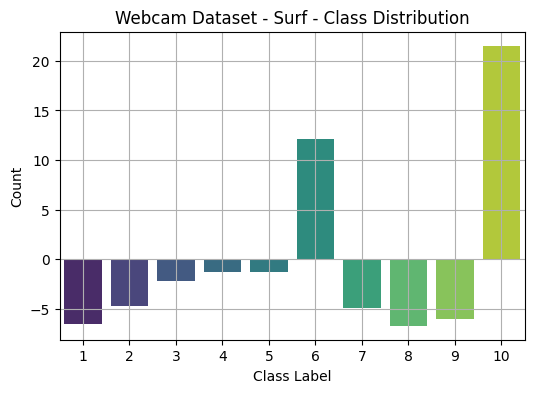

Randomly selected 20 features for visualization.


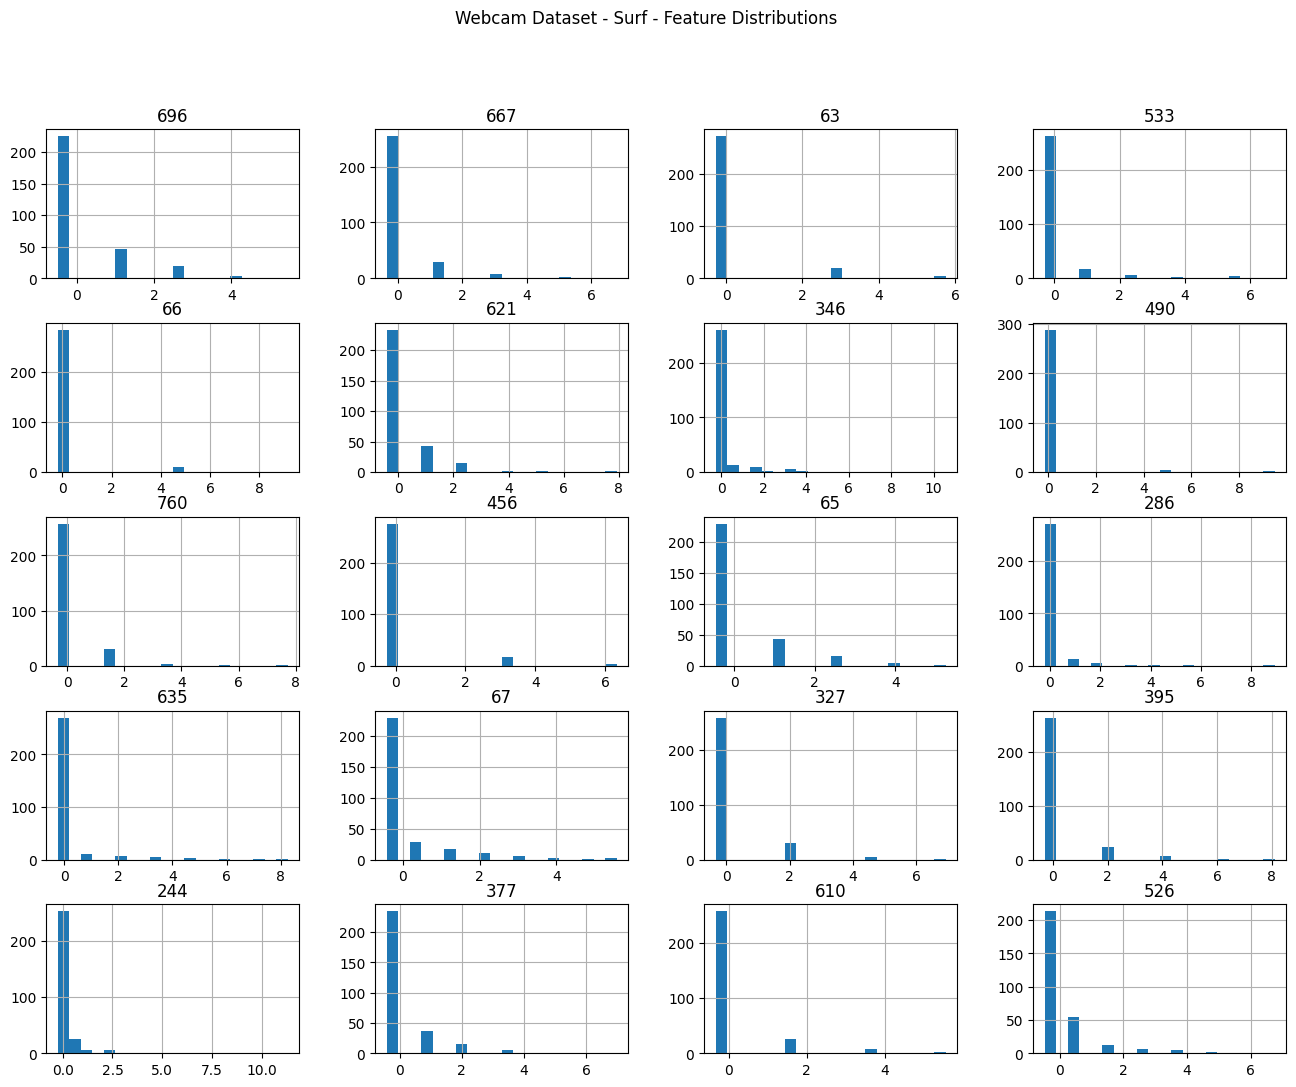

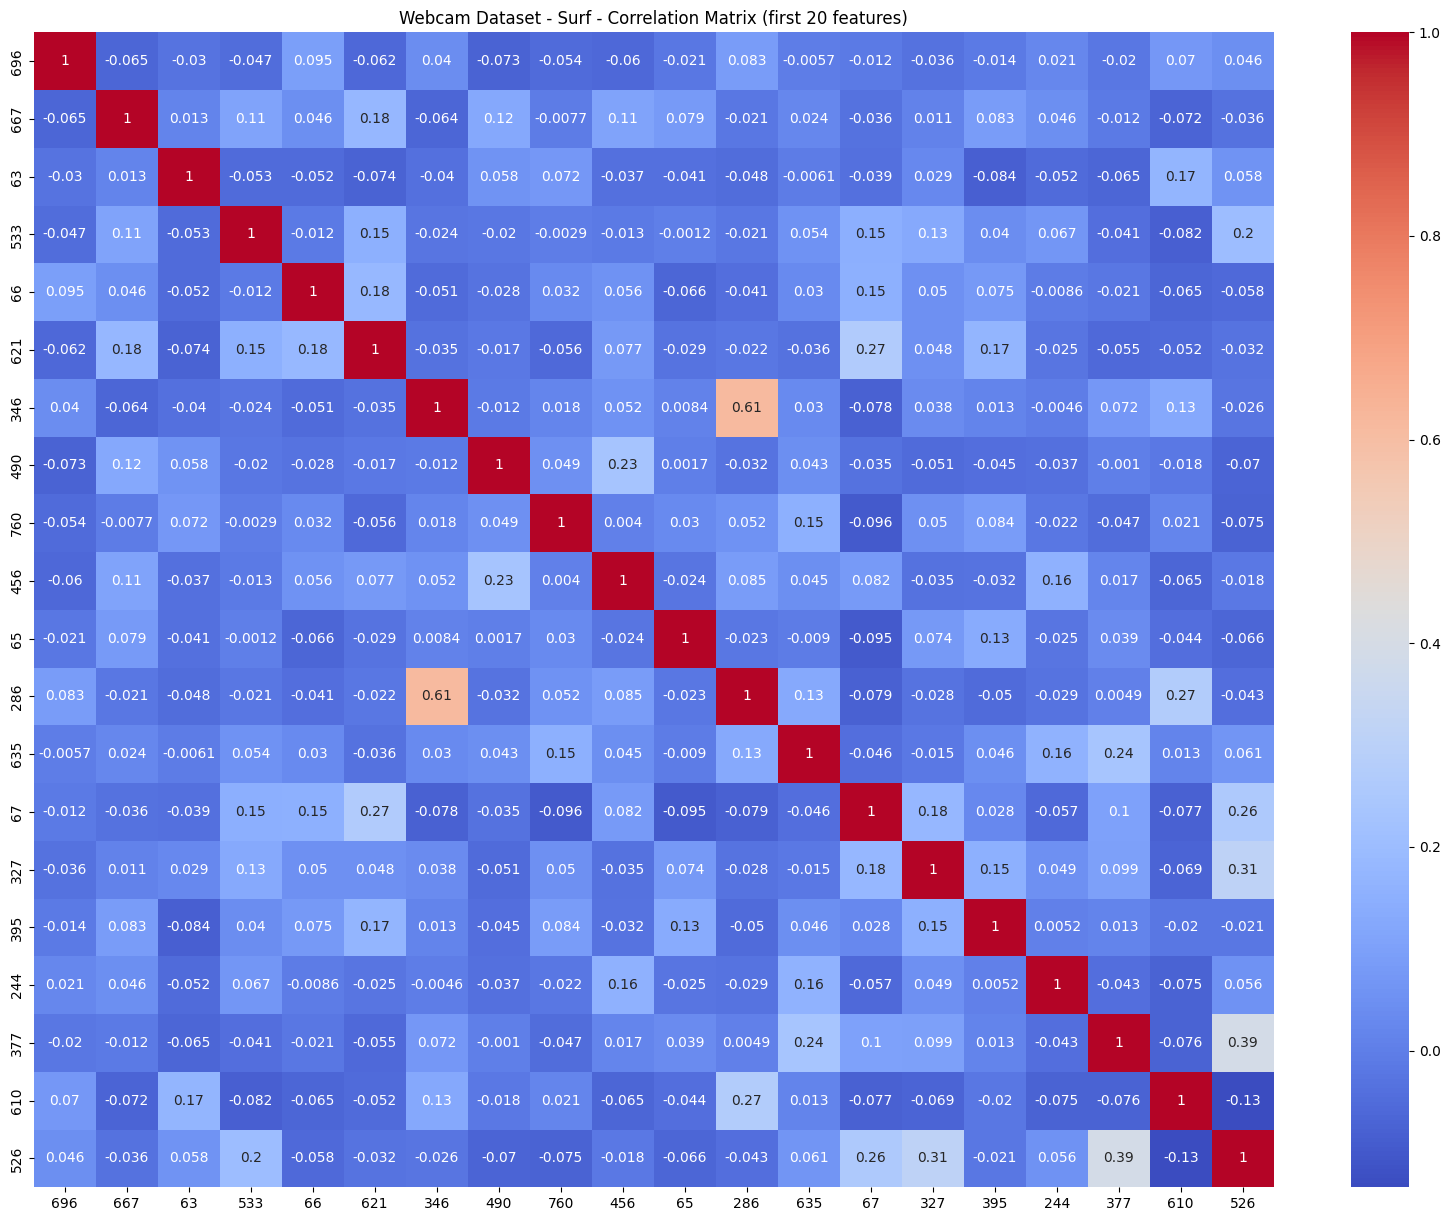


Number of potential outliers detected: 119


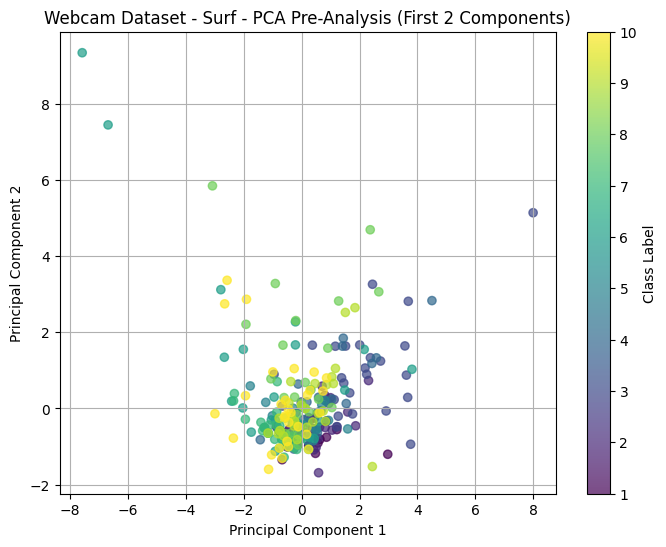

In [6]:
# For Webcam dataset- SURF
eda_on_dataset(X_webcam_surf, y_webcam_surf, dataset_name="Webcam Dataset - Surf", max_features=20)

### EDA Surf dslr

--- DSLR Dataset - Surf Overview ---
Shape: (157, 801)
Missing Values:
0        0
1        0
2        0
3        0
4        0
        ..
796      0
797      0
798      0
799      0
Class    0
Length: 801, dtype: int64
Class Distribution:
Class
6     24
10    23
7     22
2     21
4     13
1     12
8     12
3     12
5     10
9      8
Name: count, dtype: int64

--- DSLR Dataset - Surf Statistical Summary (first 20 features) ---
                  0             1             2             3           4  \
count  1.570000e+02  1.570000e+02  1.570000e+02  1.570000e+02  157.000000   
mean   4.101461e-17 -3.111453e-17  2.828594e-17  2.262875e-17    0.000000   
std    1.003200e+00  1.003200e+00  1.003200e+00  1.003200e+00    1.003200   
min   -3.910990e-01 -1.813691e-01 -2.437501e-01 -4.147991e-01   -0.357373   
25%   -3.910990e-01 -1.813691e-01 -2.437501e-01 -4.147991e-01   -0.357373   
50%   -3.910990e-01 -1.813691e-01 -2.437501e-01 -4.147991e-01   -0.357373   
75%   -3.910990e-01 -1.813691e-0

C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\3373447311.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


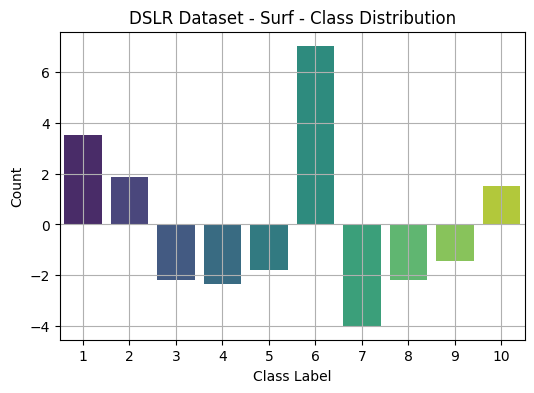

Randomly selected 20 features for visualization.


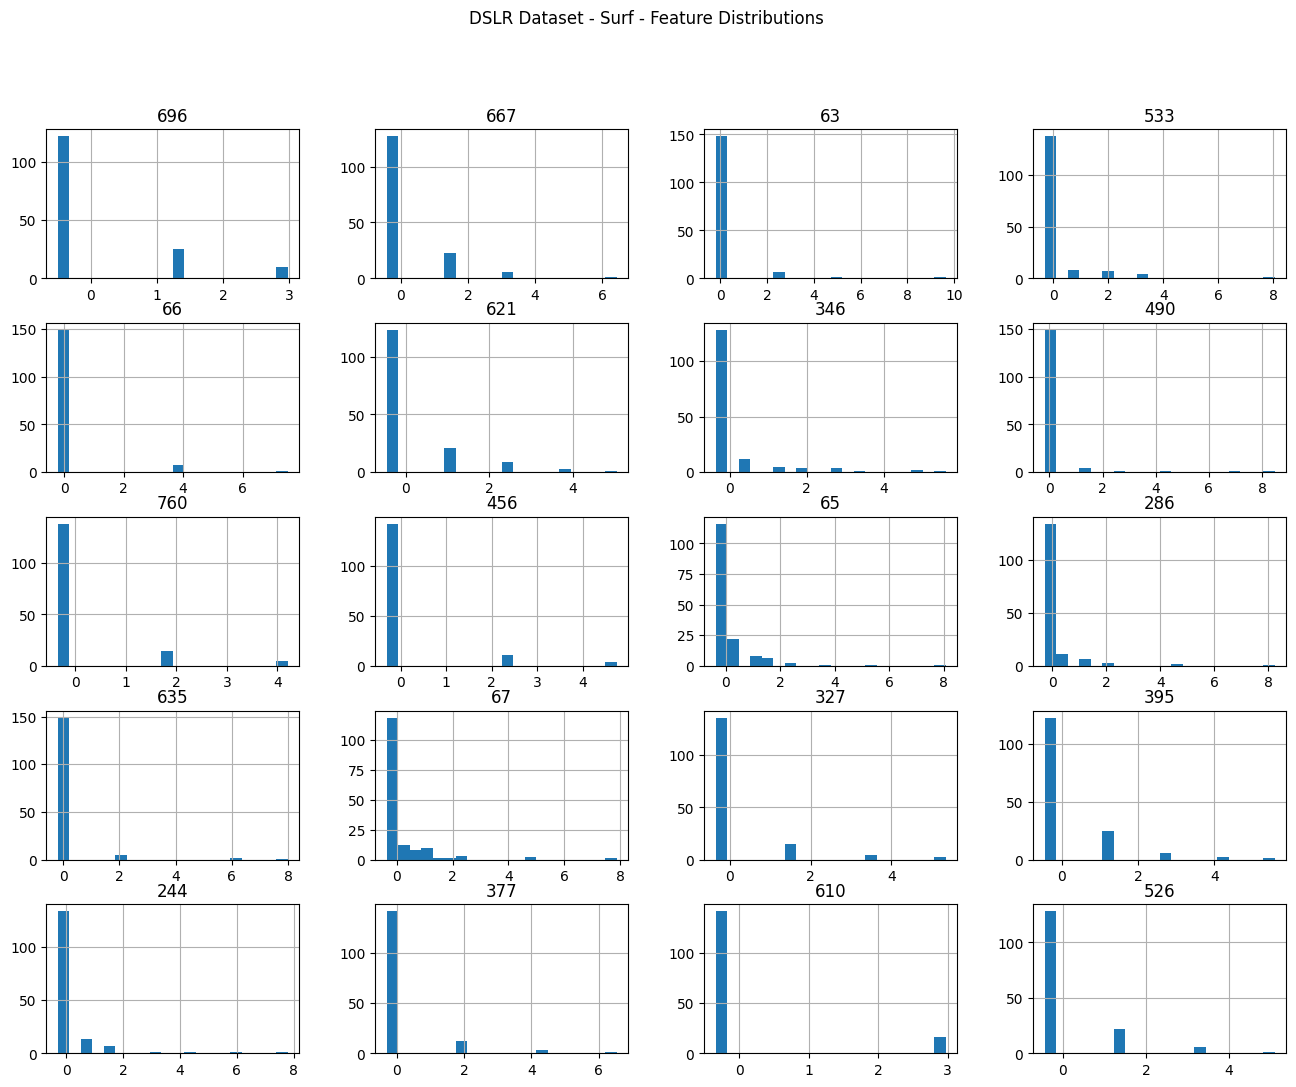

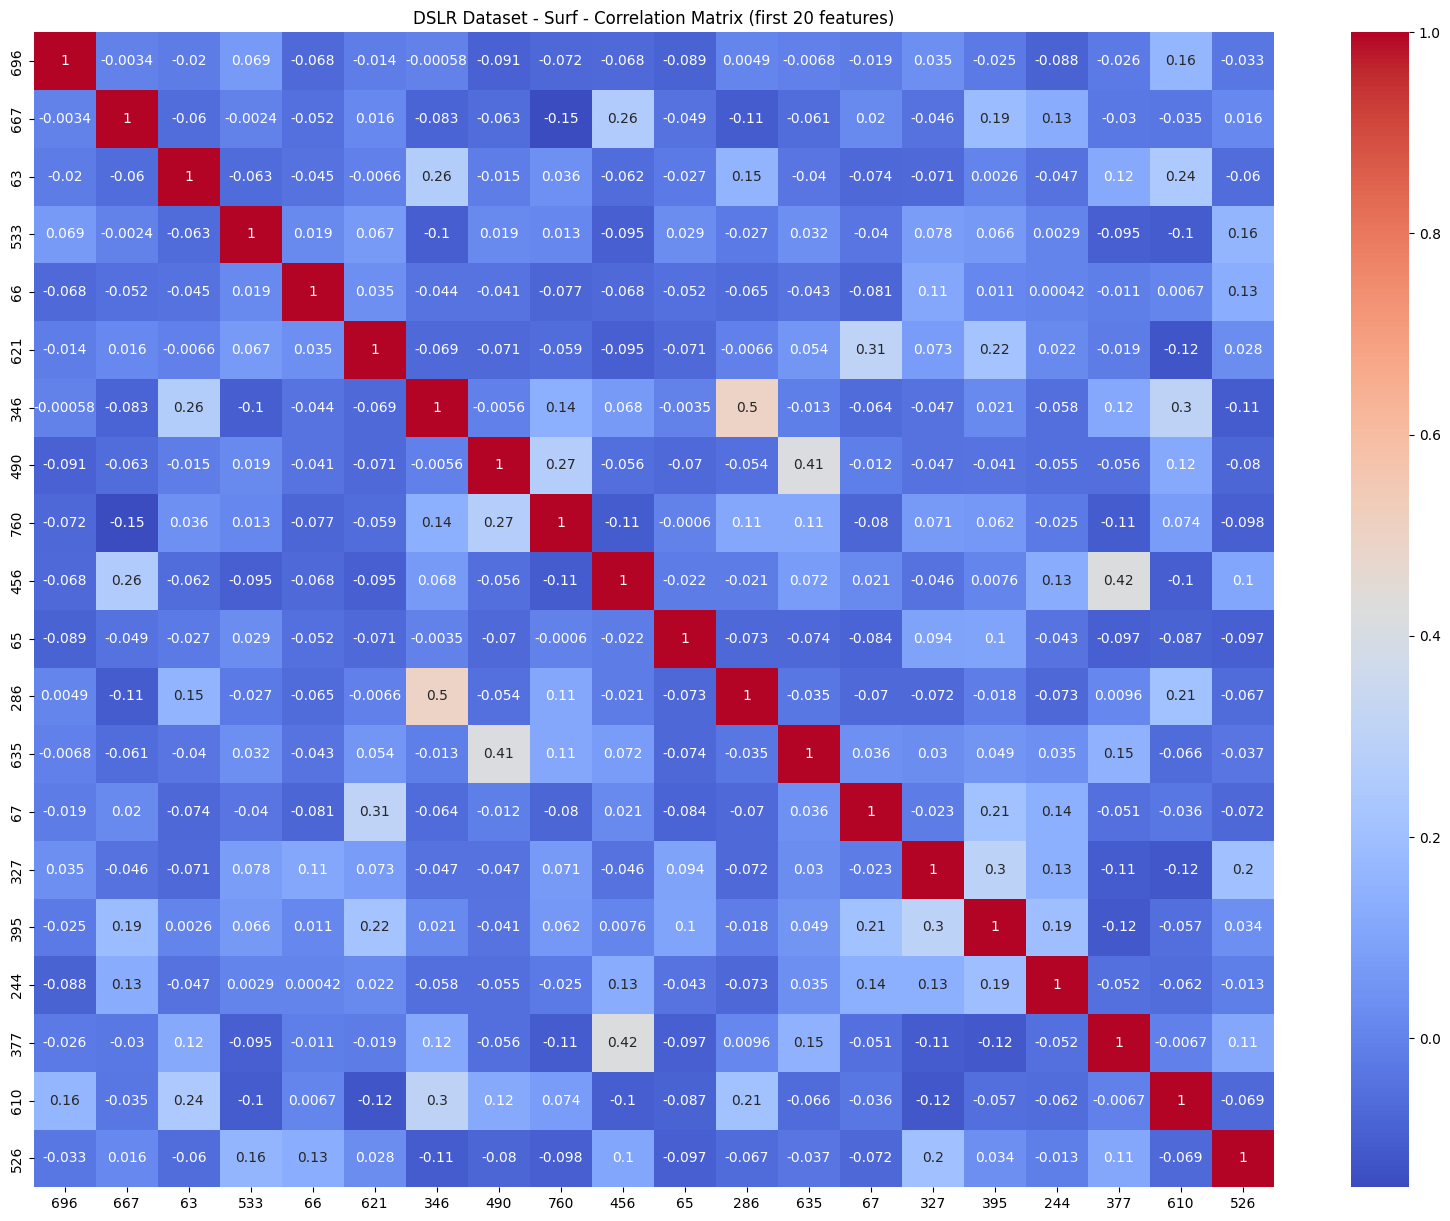


Number of potential outliers detected: 58


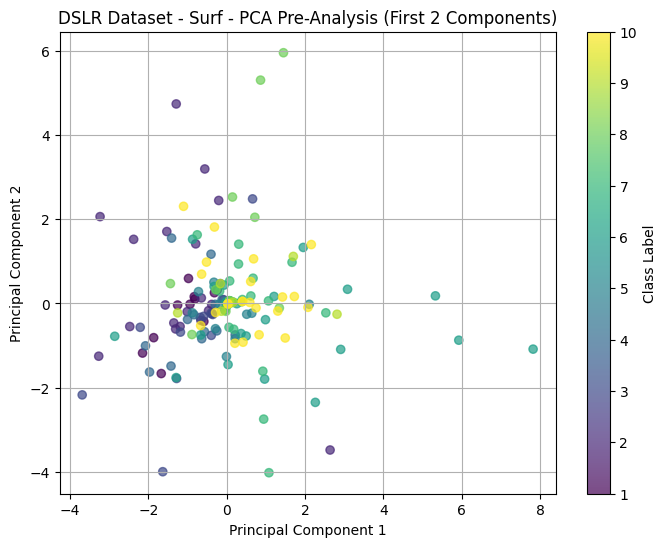

In [7]:
# For DSLR dataset - SURF
eda_on_dataset(X_dslr_surf, y_dslr_surf, dataset_name="DSLR Dataset - Surf", max_features=20)

### EDA CafeNet Webcam

--- Webcam Dataset Overview ---
Shape: (295, 4097)
Missing Values:
0        0
1        0
2        0
3        0
4        0
        ..
4092     0
4093     0
4094     0
4095     0
Class    0
Length: 4097, dtype: int64
Class Distribution:
Class
7     43
3     31
10    30
6     30
8     30
1     29
5     27
4     27
9     27
2     21
Name: count, dtype: int64

--- Webcam Dataset Statistical Summary (first 20 features) ---
                  0             1             2             3             4  \
count  2.950000e+02  2.950000e+02  2.950000e+02  2.950000e+02  2.950000e+02   
mean   2.909515e-08  3.232794e-09 -3.879353e-08  2.909515e-08  2.586235e-08   
std    1.001699e+00  1.001699e+00  1.001699e+00  1.001699e+00  1.001699e+00   
min   -2.228931e-01 -3.689248e-01 -7.163958e-01 -2.972000e-01 -4.816566e-01   
25%   -2.228931e-01 -3.689248e-01 -7.163958e-01 -2.972000e-01 -4.816566e-01   
50%   -2.228931e-01 -3.689248e-01 -4.929201e-01 -2.972000e-01 -4.816566e-01   
75%   -2.228931e-01 -2.708

C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\3373447311.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


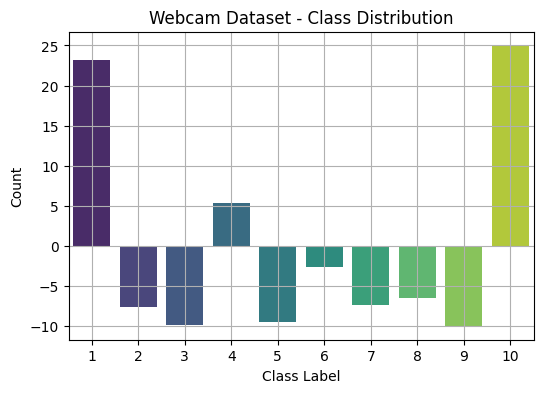

Randomly selected 20 features for visualization.


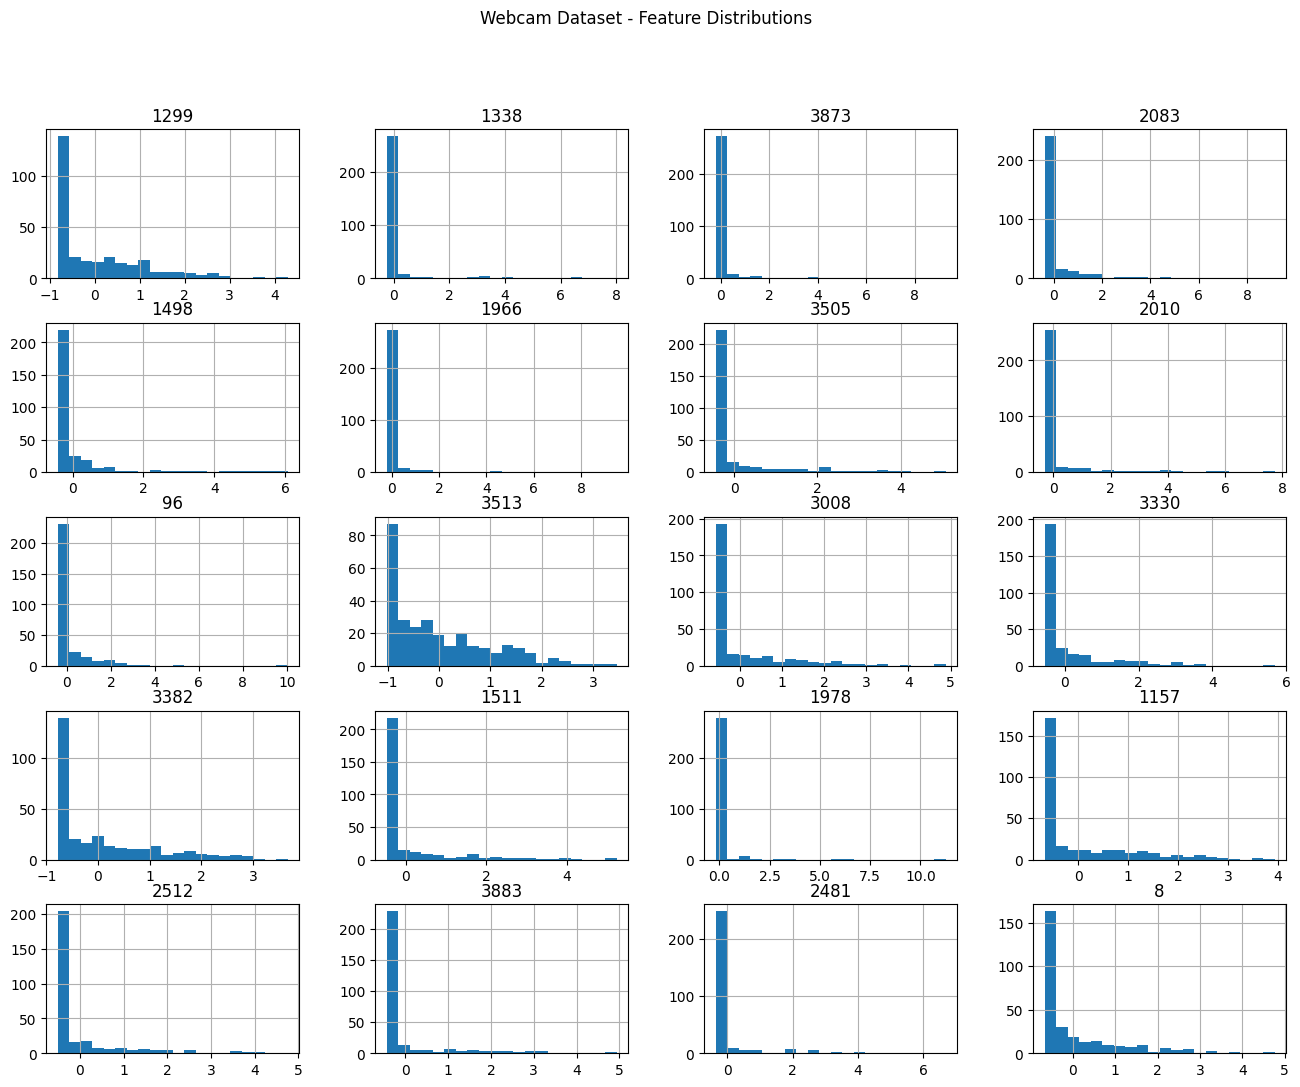

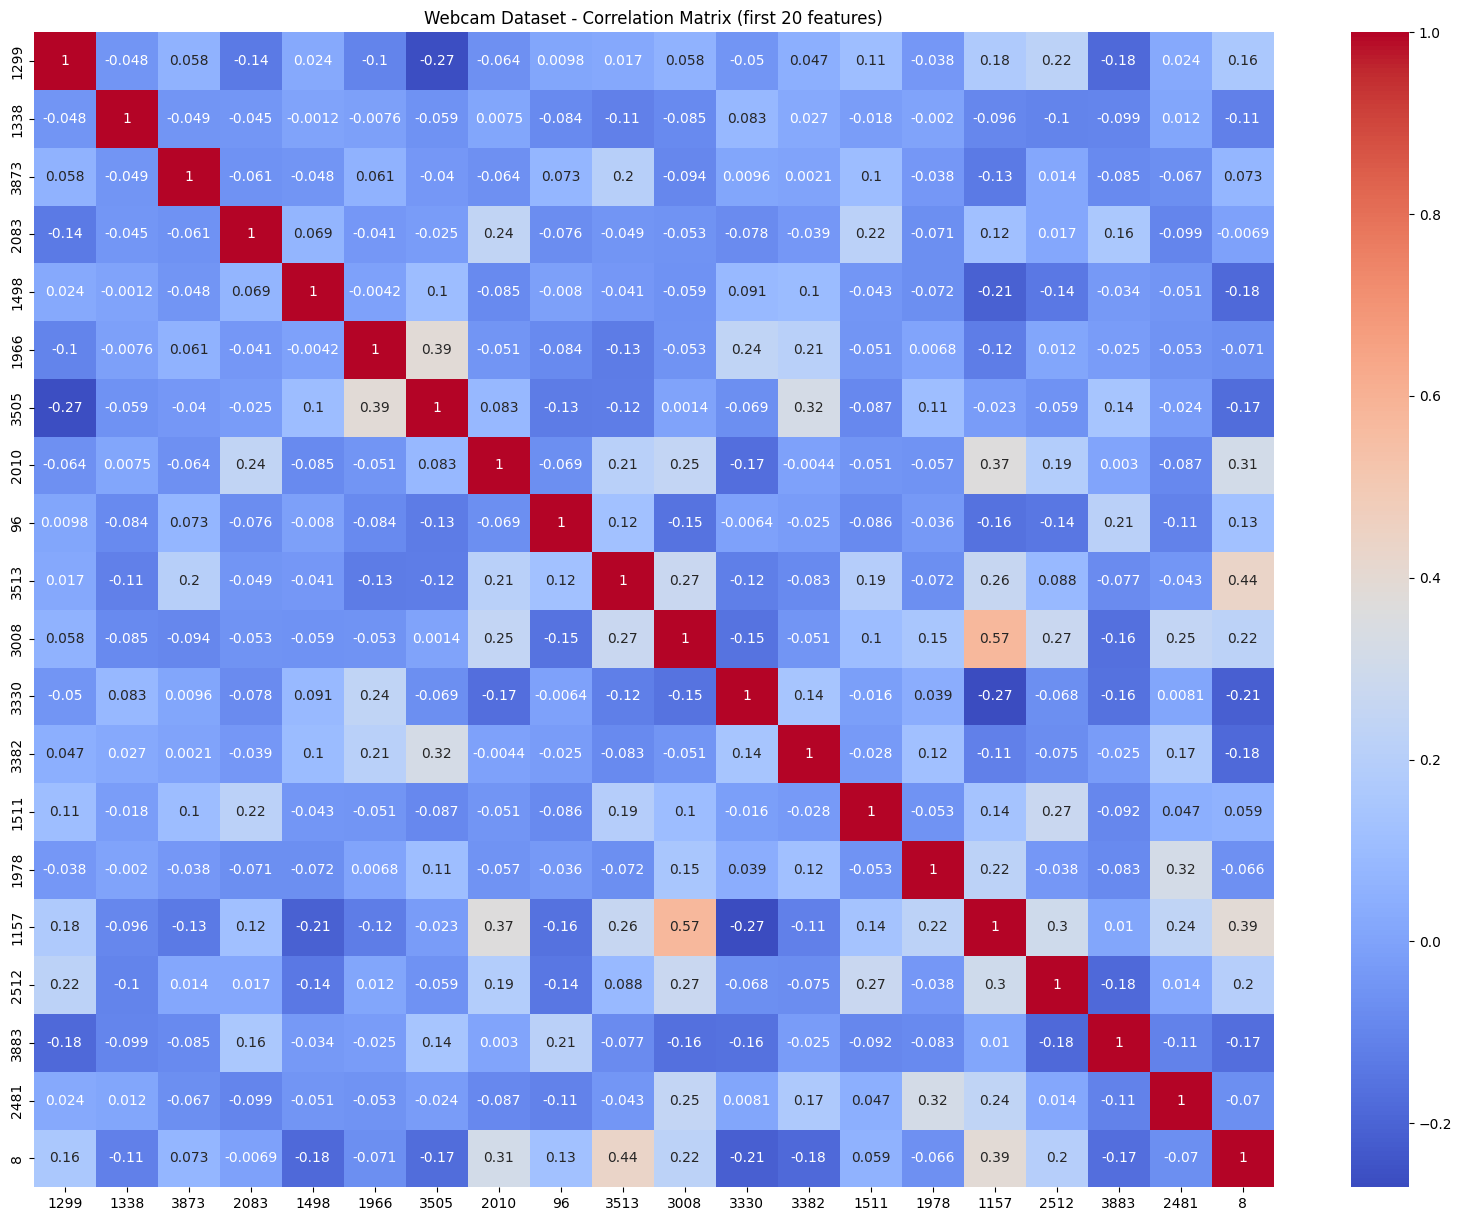


Number of potential outliers detected: 113


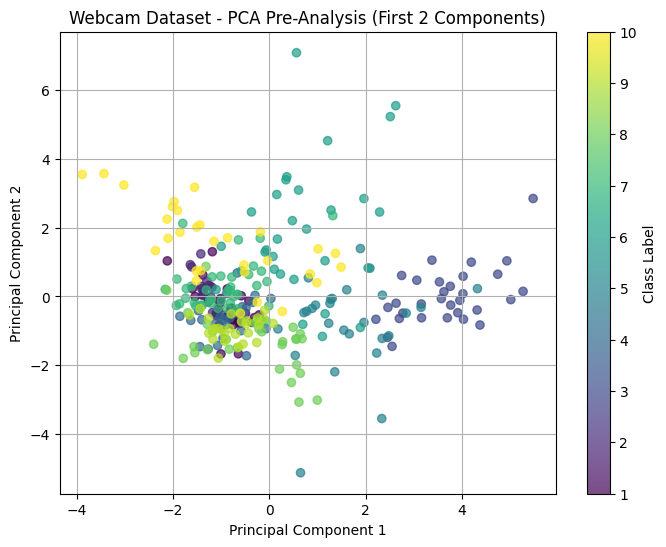

In [8]:
# For Webcam dataset - CaffeNet
eda_on_dataset(X_webcam_caf, y_webcam_caf, dataset_name="Webcam Dataset", max_features=20)

### EDA CafeNet dlsr

--- DSLR Dataset Overview ---
Shape: (157, 801)
Missing Values:
0        0
1        0
2        0
3        0
4        0
        ..
796      0
797      0
798      0
799      0
Class    0
Length: 801, dtype: int64
Class Distribution:
Class
6     24
10    23
7     22
2     21
4     13
1     12
8     12
3     12
5     10
9      8
Name: count, dtype: int64

--- DSLR Dataset Statistical Summary (first 20 features) ---
                  0             1             2             3           4  \
count  1.570000e+02  1.570000e+02  1.570000e+02  1.570000e+02  157.000000   
mean   4.101461e-17 -3.111453e-17  2.828594e-17  2.262875e-17    0.000000   
std    1.003200e+00  1.003200e+00  1.003200e+00  1.003200e+00    1.003200   
min   -3.910990e-01 -1.813691e-01 -2.437501e-01 -4.147991e-01   -0.357373   
25%   -3.910990e-01 -1.813691e-01 -2.437501e-01 -4.147991e-01   -0.357373   
50%   -3.910990e-01 -1.813691e-01 -2.437501e-01 -4.147991e-01   -0.357373   
75%   -3.910990e-01 -1.813691e-01 -2.437501e-0

C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\3373447311.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


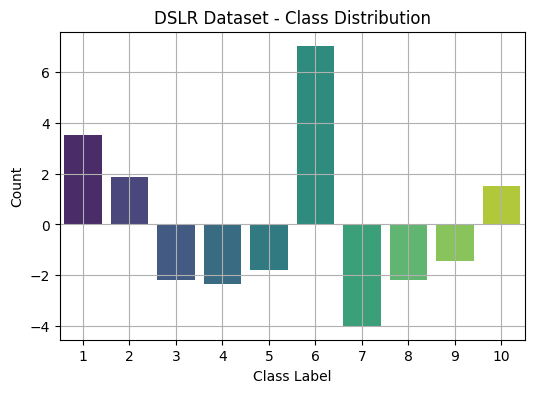

Randomly selected 20 features for visualization.


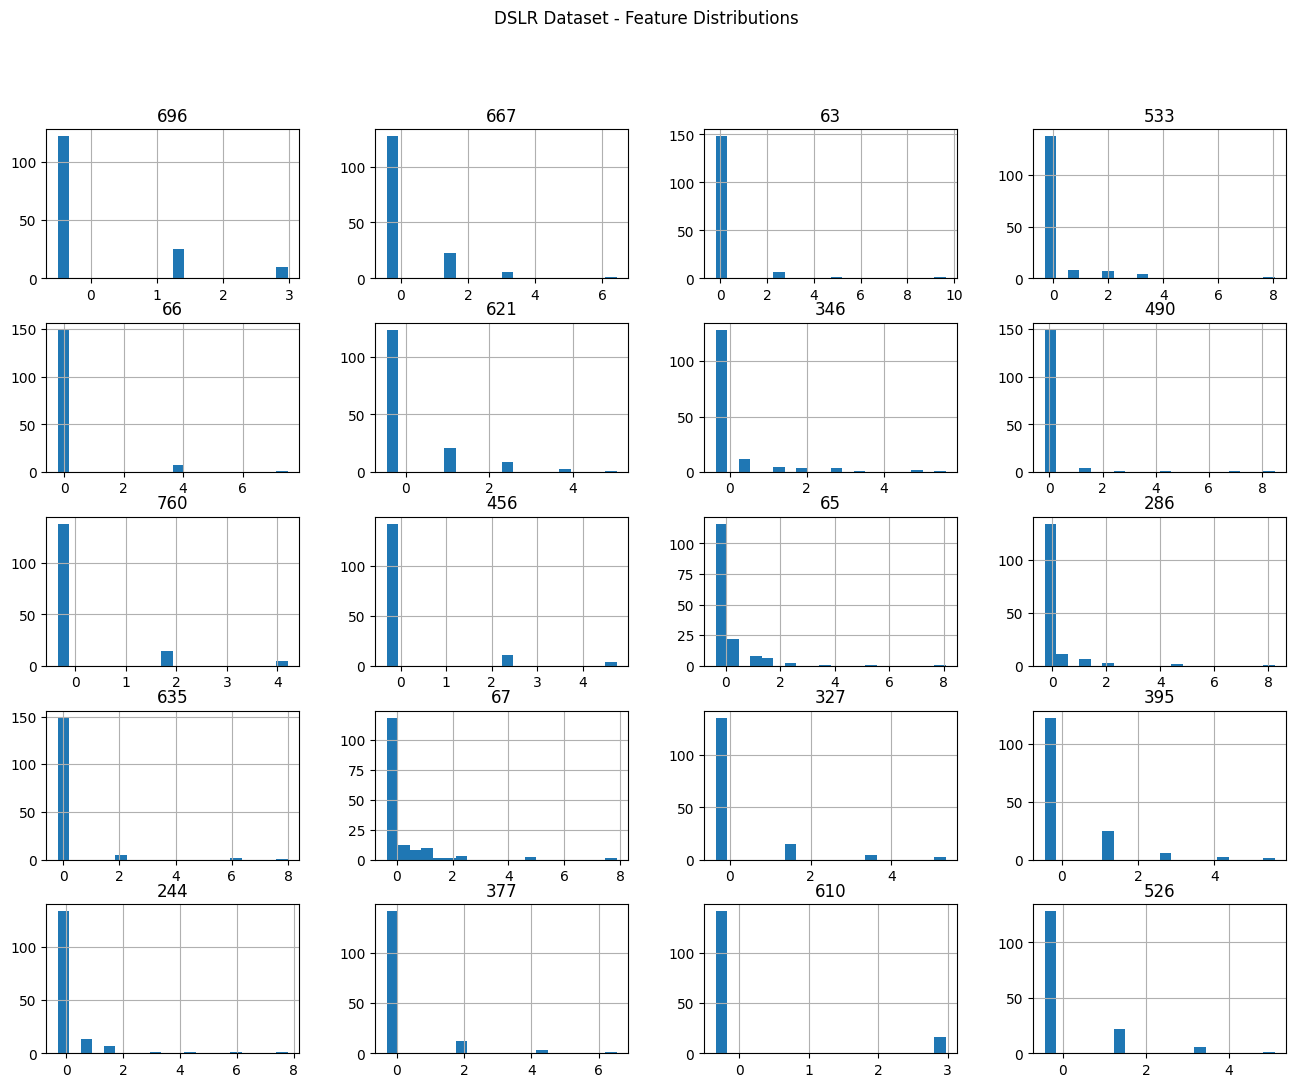

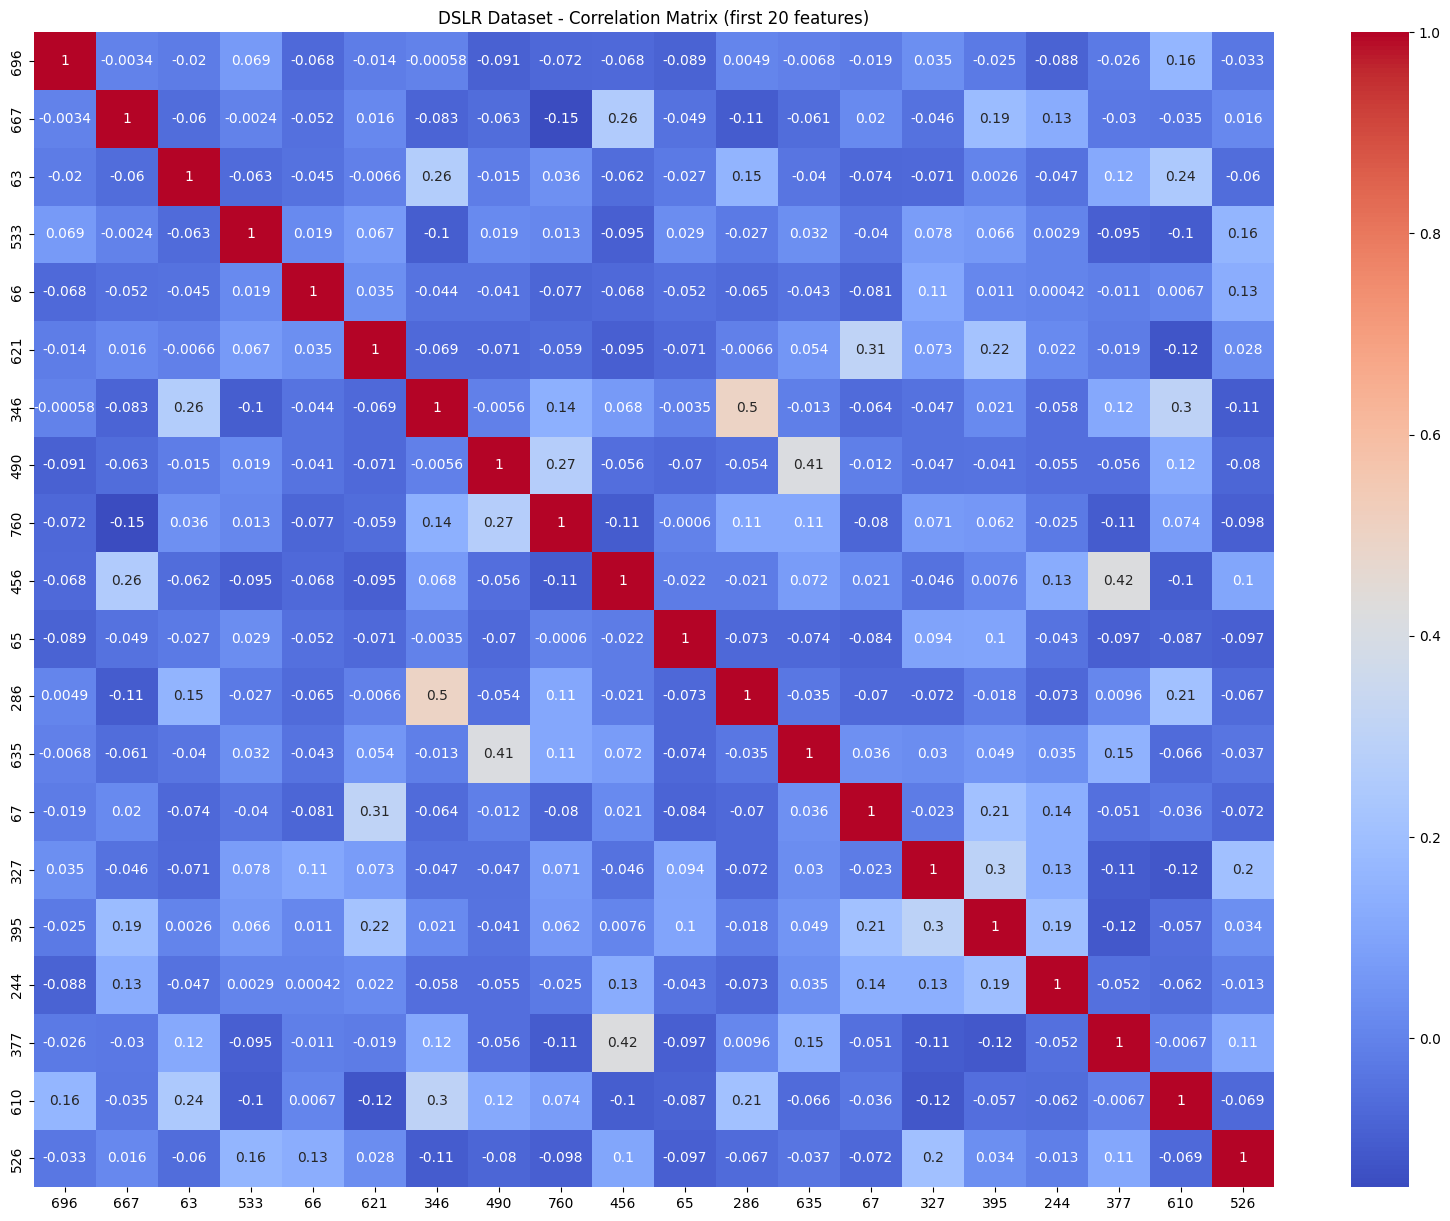


Number of potential outliers detected: 58


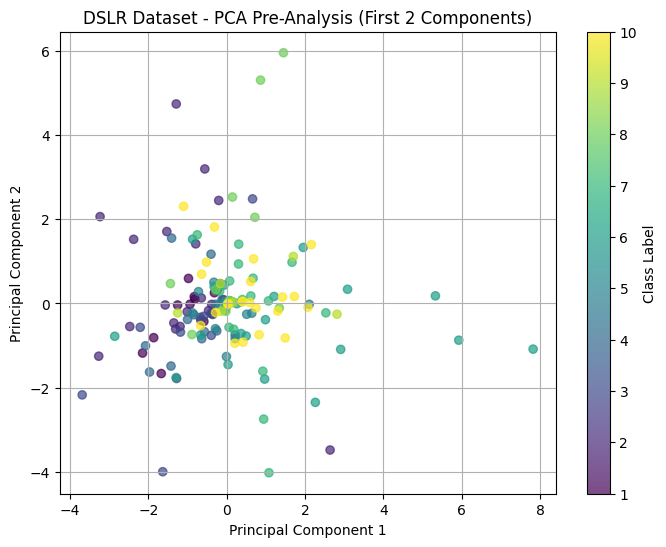

In [9]:
# For DSLR dataset - CaffeNet
eda_on_dataset(X_dslr_caf, y_dslr_caf, dataset_name="DSLR Dataset", max_features=20)


## The PROBLEMS in the DATASETS

Based on the exploratory data analysis (EDA) performed on the given datasets (Webcam and DSLR), several key issues were identified that can significantly impact the performance of any machine learning or domain adaptation models applied to them. These issues are:

### 1. **Class Imbalance**
   - The class distribution across both the Webcam and DSLR datasets is highly skewed. This means that certain classes are over-represented while others are under-represented. For example, in the Webcam dataset, classes like 1 and 10 have significantly more samples compared to other classes. In contrast, the DSLR dataset exhibits an even more severe imbalance with some classes having only a few samples. 
   - Class imbalance can lead to biased models that perform well on majority classes but poorly on minority classes, reducing overall model generalization and performance.

### 2. **Feature Distributions**
   - The feature distributions for both datasets are non-uniform and contain many zero values. This indicates sparsity in the feature space, which can complicate learning and lead to suboptimal model performance.
   - In addition to sparsity, the distributions show that a few features are highly skewed, which might dominate the variance and could potentially mislead dimensionality reduction techniques like PCA.

### 3. **Outliers and Noise**
   - Multiple features exhibit extreme values that can be considered as potential outliers. For instance, some features have a very large range compared to others, suggesting the presence of noise in the data.
   - Outliers can significantly affect the mean and covariance calculations used in PCA, leading to an inaccurate representation of the data and, consequently, poor performance of models built on these representations.

### 4. **Correlation and Redundancy in Features**
   - The correlation matrix reveals that several features are highly correlated, indicating redundancy in the data. Redundant features can cause dimensionality reduction methods to assign more variance to those features, which might not necessarily be beneficial for model performance.
   - High correlations between features can also result in instability in the models and poor generalization on unseen data, making it harder for the model to differentiate between classes.

### 5. **Different Data Scales**
   - The values of different features vary significantly in scale. For example, certain features have maximum values in the tens or hundreds, while others have values close to zero. This difference in scale can skew the results of machine learning algorithms that assume features are on similar scales (e.g., PCA or k-nearest neighbors).

### 6. **Lack of Uniformity in Class Distributions Across Domains**
   - The class distributions differ significantly between the Webcam and DSLR datasets, further complicating the domain adaptation process. While certain classes are well represented in the Webcam dataset, they may be missing or under-represented in the DSLR dataset.
   - This lack of alignment in class distributions can hinder the transfer learning process, as the feature representations learned from one domain may not generalize well to the other domain due to class-specific biases.

### 7. **High Dimensionality**
   - The Webcam and DSLR datasets have a high number of features (801 and 4097 features for SURF and CaffeNet, respectively). High dimensionality can lead to the "curse of dimensionality," where the distance between points becomes less meaningful, and models can suffer from overfitting due to too many parameters relative to the number of samples.
   - Moreover, high-dimensional datasets are more prone to overfitting, particularly when the number of samples is relatively low, as is the case here.

### 8. **Sparse Class Representation**
   - Several classes have very few samples, especially in the DSLR dataset. This sparsity makes it difficult for the model to learn meaningful patterns for these classes, potentially leading to poor classification accuracy and a high variance in model predictions.

### 9. **Potential Domain Shift**
   - The differences in feature distributions between the Webcam and DSLR datasets indicate a potential domain shift problem. This domain shift could arise from differences in camera settings, lighting conditions, or angles of object capture.
   - Domain shift makes it challenging to apply traditional supervised learning methods, as the models trained on one domain (e.g., Webcam) may not perform well when applied to a different domain (e.g., DSLR) due to changes in data distributions.

Addressing these issues is crucial before proceeding to model training and domain adaptation.

## Handling Class-Imbalance

In [10]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def handle_class_imbalance(X, y, sampling_strategy='auto', random_state=42, display=True):
    """
    Apply SMOTE to handle class imbalance in the dataset.
    
    Args:
    - X (np.array): Feature matrix.
    - y (np.array): Target labels.
    - sampling_strategy (str or dict): Sampling strategy for SMOTE.
    - random_state (int): Random state for reproducibility.
    - display (bool): Whether to display class distribution plots.
    
    Returns:
    - X_resampled (np.array): Resampled feature matrix.
    - y_resampled (np.array): Resampled target labels.
    """
    print(f"Original class distribution: {Counter(y)}")
    
    # Apply SMOTE
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    print(f"Resampled class distribution: {Counter(y_resampled)}")
    
    # Plot class distribution before and after resampling
    if display:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        sns.countplot(x=y, ax=axes[0], palette='viridis')
        axes[0].set_title('Original Class Distribution')
        sns.countplot(x=y_resampled, ax=axes[1], palette='viridis')
        axes[1].set_title('Resampled Class Distribution')
        plt.show()
    
    return X_resampled, y_resampled


Original class distribution: Counter({np.uint8(7): 43, np.uint8(3): 31, np.uint8(6): 30, np.uint8(8): 30, np.uint8(10): 30, np.uint8(1): 29, np.uint8(4): 27, np.uint8(5): 27, np.uint8(9): 27, np.uint8(2): 21})
Resampled class distribution: Counter({np.uint8(1): 43, np.uint8(2): 43, np.uint8(3): 43, np.uint8(4): 43, np.uint8(5): 43, np.uint8(6): 43, np.uint8(7): 43, np.uint8(8): 43, np.uint8(9): 43, np.uint8(10): 43})


C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=axes[0], palette='viridis')
C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, ax=axes[1], palette='viridis')


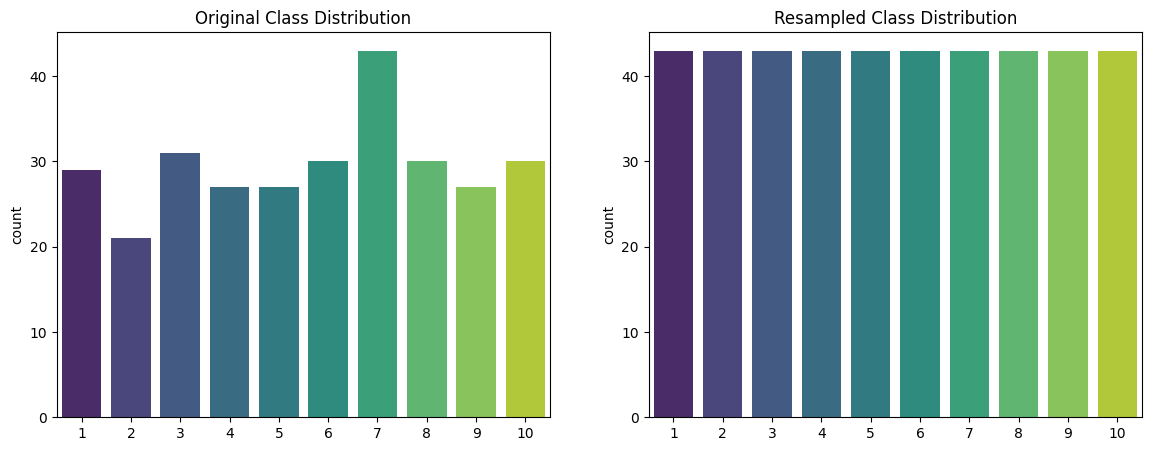

In [11]:
# SURF dataset

# Webcam
X_webcam_resampled_surf, y_webcam_resampled_surf = handle_class_imbalance(X_webcam_surf, y_webcam_surf)


Original class distribution: Counter({np.uint8(6): 24, np.uint8(10): 23, np.uint8(7): 22, np.uint8(2): 21, np.uint8(4): 13, np.uint8(1): 12, np.uint8(3): 12, np.uint8(8): 12, np.uint8(5): 10, np.uint8(9): 8})
Resampled class distribution: Counter({np.uint8(1): 24, np.uint8(2): 24, np.uint8(3): 24, np.uint8(4): 24, np.uint8(5): 24, np.uint8(6): 24, np.uint8(7): 24, np.uint8(8): 24, np.uint8(9): 24, np.uint8(10): 24})


C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=axes[0], palette='viridis')
C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, ax=axes[1], palette='viridis')


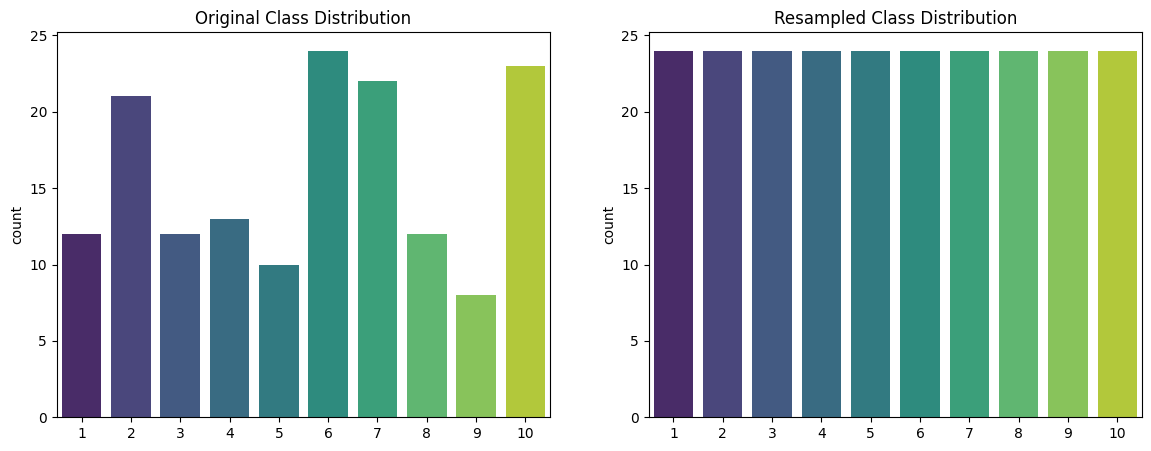

In [12]:
# SURF dataset

# DSLR
X_dslr_resampled_surf, y_dslr_resampled_surf = handle_class_imbalance(X_dslr_surf, y_dslr_surf)

Original class distribution: Counter({np.int64(7): 43, np.int64(3): 31, np.int64(6): 30, np.int64(8): 30, np.int64(10): 30, np.int64(1): 29, np.int64(4): 27, np.int64(5): 27, np.int64(9): 27, np.int64(2): 21})
Resampled class distribution: Counter({np.int64(1): 43, np.int64(2): 43, np.int64(3): 43, np.int64(4): 43, np.int64(5): 43, np.int64(6): 43, np.int64(7): 43, np.int64(8): 43, np.int64(9): 43, np.int64(10): 43})


C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=axes[0], palette='viridis')
C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, ax=axes[1], palette='viridis')


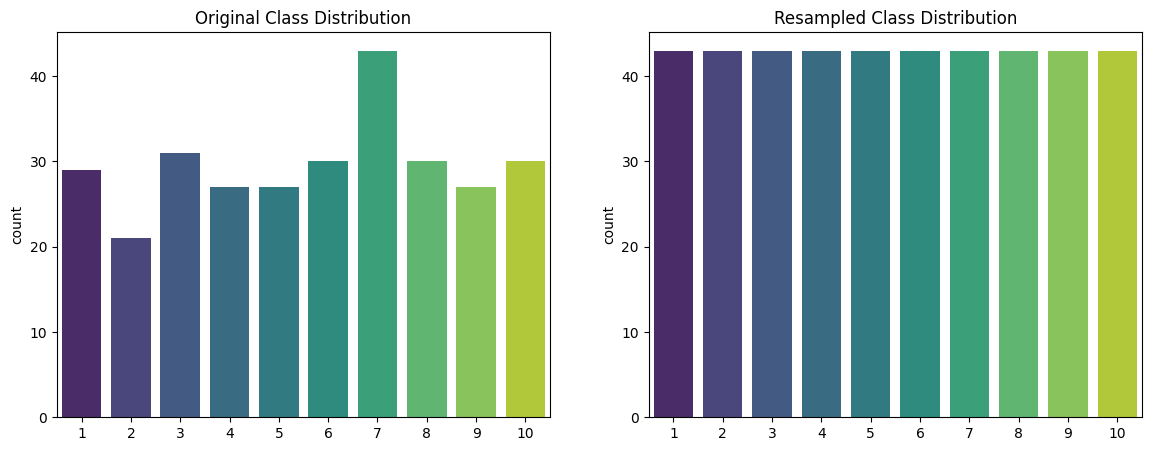

In [13]:
# CaffeNet dataset

# Webcam
X_webcam_resampled_caf, y_webcam_resampled_caf = handle_class_imbalance(X_webcam_caf, y_webcam_caf)


Original class distribution: Counter({np.uint8(6): 24, np.uint8(10): 23, np.uint8(7): 22, np.uint8(2): 21, np.uint8(4): 13, np.uint8(1): 12, np.uint8(3): 12, np.uint8(8): 12, np.uint8(5): 10, np.uint8(9): 8})
Resampled class distribution: Counter({np.uint8(1): 24, np.uint8(2): 24, np.uint8(3): 24, np.uint8(4): 24, np.uint8(5): 24, np.uint8(6): 24, np.uint8(7): 24, np.uint8(8): 24, np.uint8(9): 24, np.uint8(10): 24})


C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, ax=axes[0], palette='viridis')
C:\Users\zahir\AppData\Local\Temp\ipykernel_10352\2462017248.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled, ax=axes[1], palette='viridis')


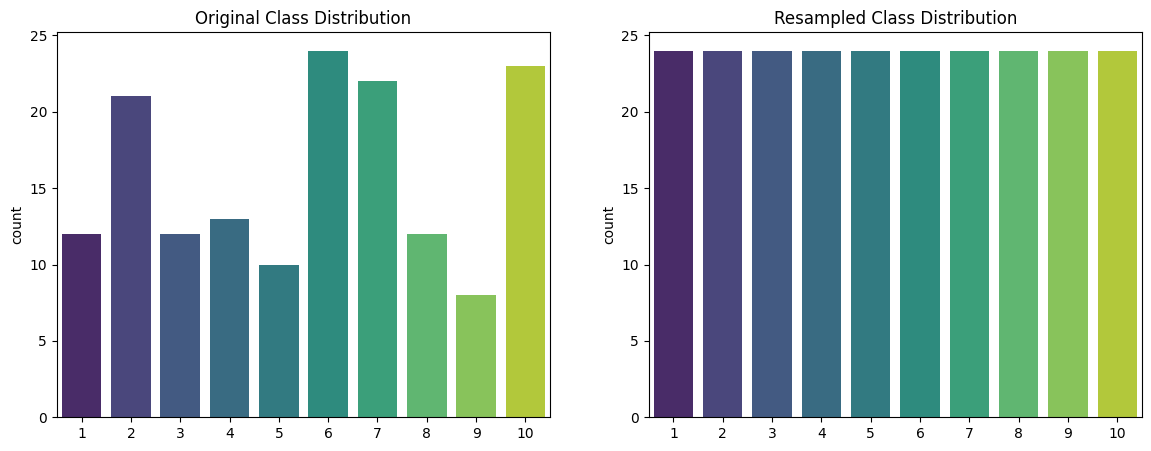

In [14]:
# CaffeNet dataset

# DSLR
X_dslr_resampled_caf, y_dslr_resampled_caf = handle_class_imbalance(X_dslr_caf, y_dslr_caf)

## Handling Outliers

In [15]:
from sklearn.ensemble import IsolationForest

def detect_outliers_with_isolation_forest(X, contamination=0.05, random_state=42):
    """
    Detect outliers using the Isolation Forest algorithm.
    
    Args:
    - X (np.ndarray): Feature matrix of shape (n_samples, n_features).
    - contamination (float): The proportion of outliers in the dataset (default: 0.05).
    - random_state (int): Random seed for reproducibility (default: 42).
    
    Returns:
    - outlier_labels (np.ndarray): Array of outlier labels (-1 for outliers, 1 for inliers).
    """
    # Initialize and fit Isolation Forest
    isolation_forest = IsolationForest(contamination=contamination, random_state=random_state)
    isolation_forest.fit(X)
    # Predict outlier labels (-1 for outliers, 1 for inliers)
    outlier_labels = isolation_forest.predict(X)
    return outlier_labels

In [16]:
# Detect outliers for SURF datasets
outlier_labels_webcam_surf = detect_outliers_with_isolation_forest(X_webcam_resampled_surf)
outlier_labels_dslr_surf = detect_outliers_with_isolation_forest(X_dslr_resampled_surf)

# Detect outliers for CaffeNet datasets
outlier_labels_webcam_caf = detect_outliers_with_isolation_forest(X_webcam_resampled_caf)
outlier_labels_dslr_caf = detect_outliers_with_isolation_forest(X_dslr_resampled_caf)

# Output number of detected outliers for verification
print(f"Number of outliers in SURF Webcam dataset: {sum(outlier_labels_webcam_surf == -1)}")
print(f"Number of outliers in SURF DSLR dataset: {sum(outlier_labels_dslr_surf == -1)}")
print(f"Number of outliers in CaffeNet Webcam dataset: {sum(outlier_labels_webcam_caf == -1)}")
print(f"Number of outliers in CaffeNet DSLR dataset: {sum(outlier_labels_dslr_caf == -1)}")

Number of outliers in SURF Webcam dataset: 22
Number of outliers in SURF DSLR dataset: 12
Number of outliers in CaffeNet Webcam dataset: 22
Number of outliers in CaffeNet DSLR dataset: 12


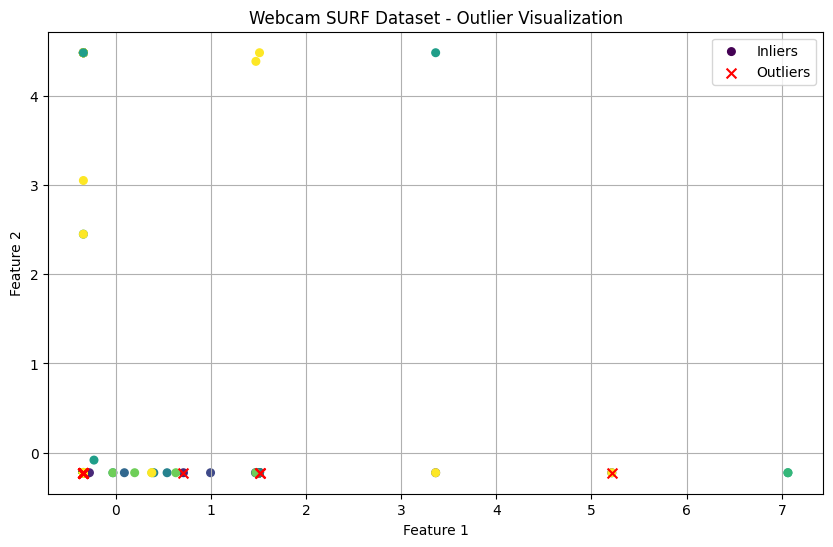

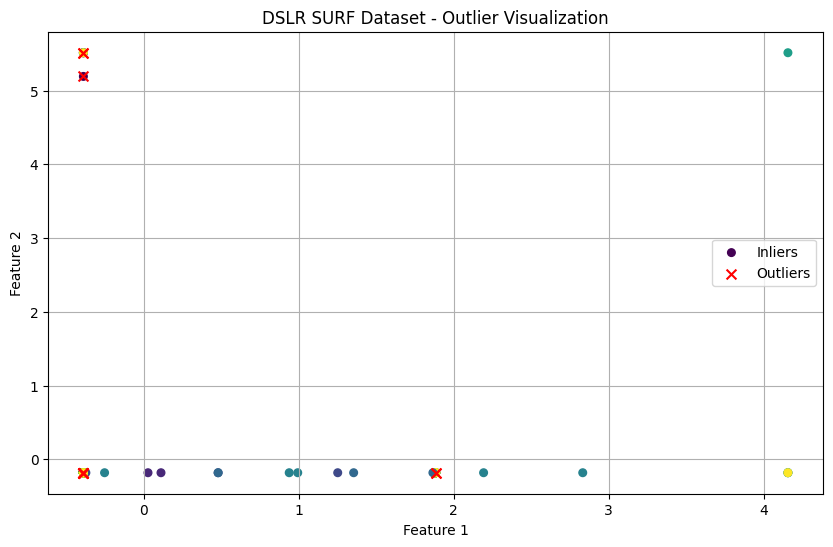

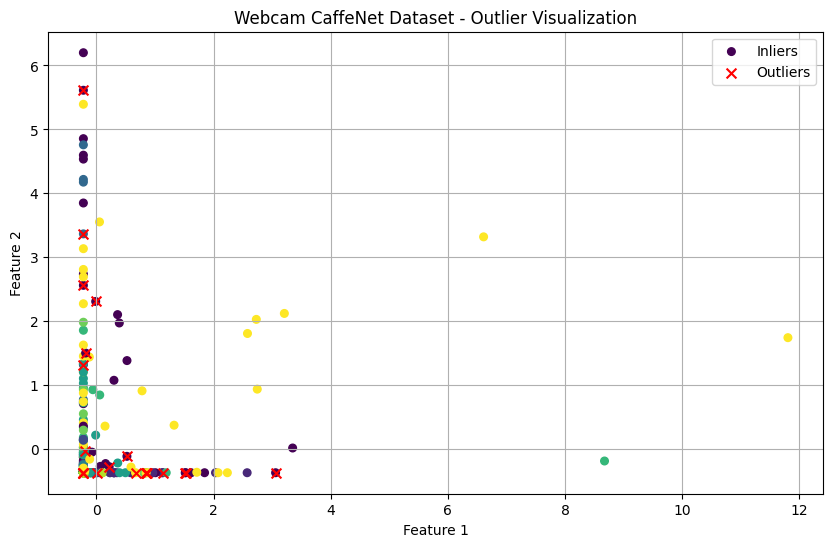

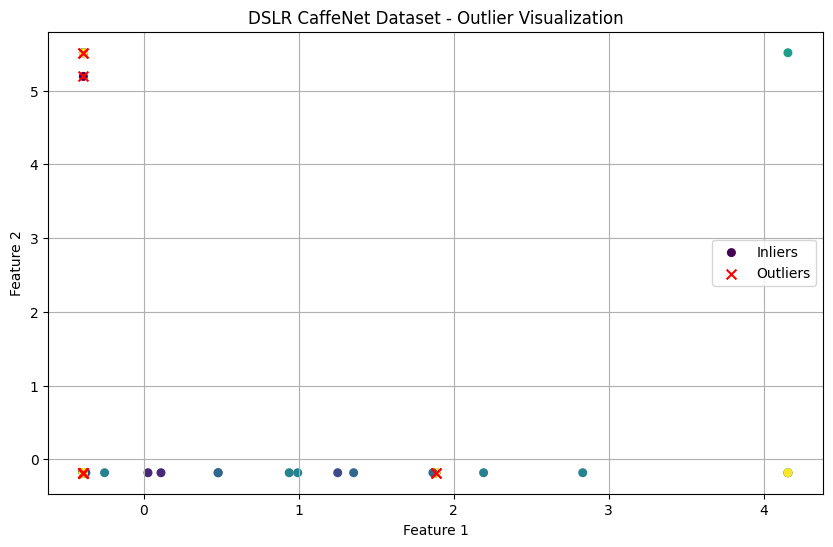

In [17]:
import matplotlib.pyplot as plt

def visualize_outliers(X, y, outlier_labels, title="Outlier Visualization"):
    """
    Visualize the dataset and highlight the detected outliers.
    
    Args:
    - X (np.ndarray): Feature matrix of shape (n_samples, n_features).
    - y (np.ndarray): Labels corresponding to the feature matrix.
    - outlier_labels (np.ndarray): Array of outlier labels (-1 for outliers, 1 for inliers).
    - title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30, label='Inliers')
    plt.scatter(X[outlier_labels == -1, 0], X[outlier_labels == -1, 1], c='red', s=50, marker='x', label='Outliers')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize for each dataset
visualize_outliers(X_webcam_resampled_surf, y_webcam_resampled_surf, outlier_labels_webcam_surf, title="Webcam SURF Dataset - Outlier Visualization")
visualize_outliers(X_dslr_resampled_surf, y_dslr_resampled_surf, outlier_labels_dslr_surf, title="DSLR SURF Dataset - Outlier Visualization")
visualize_outliers(X_webcam_resampled_caf, y_webcam_resampled_caf, outlier_labels_webcam_caf, title="Webcam CaffeNet Dataset - Outlier Visualization")
visualize_outliers(X_dslr_resampled_caf, y_dslr_resampled_caf, outlier_labels_dslr_caf, title="DSLR CaffeNet Dataset - Outlier Visualization")

In [18]:
def remove_outliers(X, y, outlier_labels):
    """
    Remove outliers from the dataset based on the outlier labels.
    
    Args:
    - X (np.ndarray): Feature matrix of shape (n_samples, n_features).
    - y (np.ndarray): Labels corresponding to the feature matrix.
    - outlier_labels (np.ndarray): Array of outlier labels (-1 for outliers, 1 for inliers).
    
    Returns:
    - X_clean (np.ndarray): Cleaned feature matrix without outliers.
    - y_clean (np.ndarray): Cleaned labels without outliers.
    """
    mask = outlier_labels == 1  # Keep only inliers
    X_clean = X[mask]
    y_clean = y[mask]
    return X_clean, y_clean

# Remove outliers for each dataset
X_webcam_clean_surf, y_webcam_clean_surf = remove_outliers(X_webcam_resampled_surf, y_webcam_resampled_surf, outlier_labels_webcam_surf)
X_dslr_clean_surf, y_dslr_clean_surf = remove_outliers(X_dslr_resampled_surf, y_dslr_resampled_surf, outlier_labels_dslr_surf)
X_webcam_clean_caf, y_webcam_clean_caf = remove_outliers(X_webcam_resampled_caf, y_webcam_resampled_caf, outlier_labels_webcam_caf)
X_dslr_clean_caf, y_dslr_clean_caf = remove_outliers(X_dslr_resampled_caf, y_dslr_resampled_caf, outlier_labels_dslr_caf)

# Final shapes after handling outliers
print(f"Webcam SURF dataset shape after outlier removal: {X_webcam_clean_surf.shape}, {y_webcam_clean_surf.shape}")
print(f"DSLR SURF dataset shape after outlier removal: {X_dslr_clean_surf.shape}, {y_dslr_clean_surf.shape}")
print(f"Webcam CaffeNet dataset shape after outlier removal: {X_webcam_clean_caf.shape}, {y_webcam_clean_caf.shape}")
print(f"DSLR CaffeNet dataset shape after outlier removal: {X_dslr_clean_caf.shape}, {y_dslr_clean_caf.shape}")

Webcam SURF dataset shape after outlier removal: (408, 800), (408,)
DSLR SURF dataset shape after outlier removal: (228, 800), (228,)
Webcam CaffeNet dataset shape after outlier removal: (408, 4096), (408,)
DSLR CaffeNet dataset shape after outlier removal: (228, 800), (228,)


# PCA with Dynamice D Selection

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator
from typing import List, Tuple, Optional

def pca_with_dynamic_d(X: np.ndarray, variance_threshold: float = 0.90, plot_variance: bool = False) -> Tuple[np.ndarray, int]:
    """
    Perform PCA with dynamic selection of the number of components based on variance threshold.
    
    Args:
    - X: Feature matrix of shape (n_samples, n_features).
    - variance_threshold: The cumulative variance ratio to be retained (e.g., 0.90 for 90%).
    - plot_variance: Whether to plot the cumulative explained variance.
    
    Returns:
    - X_pca: PCA-transformed feature matrix with optimal number of components.
    - n_components: Number of components selected based on the variance threshold.
    """
    pca = PCA().fit(X)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()
    
    n_components = next(i for i, total in enumerate(cumulative_variance) if total >= variance_threshold) + 1
    
    pca_optimal = PCA(n_components=n_components)
    X_pca = pca_optimal.fit_transform(X)
    
    if plot_variance:
        plt.figure(figsize=(8, 5))
        plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
        plt.axhline(y=variance_threshold, color='r', linestyle='-')
        plt.title(f'Cumulative Explained Variance with Optimal D = {n_components}')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid(True)
        plt.show()
    
    print(f"Optimal number of components to retain {variance_threshold * 100}% variance: {n_components}")
    return X_pca, n_components

def evaluate_pca_performance(X_pca: np.ndarray, y: np.ndarray, classifier: BaseEstimator = KNeighborsClassifier(n_neighbors=1), cv: int = 5) -> float:
    """
    Evaluate PCA performance using cross-validation with a specified classifier.
    
    Args:
    - X_pca: PCA-transformed feature matrix.
    - y: Labels corresponding to the feature matrix.
    - classifier: Classifier to use for evaluation (default: 1-NN).
    - cv: Number of cross-validation folds (default: 5).
    
    Returns:
    - mean_accuracy: Mean cross-validation accuracy score.
    """
    scores = cross_val_score(classifier, X_pca, y, cv=cv)
    mean_accuracy = np.mean(scores)
    return mean_accuracy

def tune_pca_with_visualizations(X: np.ndarray, y: np.ndarray, 
                                 thresholds: List[float] = [0.80, 0.85, 0.90, 0.95, 0.99],
                                 classifier: BaseEstimator = KNeighborsClassifier(n_neighbors=1),
                                 cv: int = 5,
                                 save_plots: bool = False,
                                 plot_prefix: str = "pca_tuning") -> Tuple[PCA, float, int, float]:
    """
    Tune PCA and visualize results for different variance thresholds.
    
    Args:
    - X: Feature matrix of shape (n_samples, n_features).
    - y: Labels corresponding to the feature matrix.
    - thresholds: List of variance thresholds to evaluate.
    - classifier: Classifier to use for evaluation (default: 1-NN).
    - cv: Number of cross-validation folds (default: 5).
    - save_plots: Whether to save plots to files instead of displaying them (default: False).
    - plot_prefix: Prefix for saved plot filenames (default: "pca_tuning").

    Returns:
    - best_pca_model: PCA model with the optimal variance threshold and number of components.
    - best_threshold: Optimal variance threshold.
    - best_n_components: Optimal number of components.
    - best_score: Performance score with the optimal PCA configuration.
    """
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise ValueError("X and y must be numpy arrays.")
    if X.shape[0] != y.shape[0]:
        raise ValueError("X and y must have the same number of samples.")
    
    best_score = -np.inf
    best_pca_model = None
    best_threshold = None
    best_n_components = None
    performance_scores = []
    num_components_list = []

    for variance_threshold in thresholds:
        X_pca, n_components = pca_with_dynamic_d(X, variance_threshold=variance_threshold)
        score = evaluate_pca_performance(X_pca, y, classifier=classifier, cv=cv)
        
        performance_scores.append(score)
        num_components_list.append(n_components)

        if score > best_score:
            best_score = score
            best_pca_model = PCA(n_components=n_components)
            best_pca_model.fit(X)
            best_threshold = variance_threshold
            best_n_components = n_components
            
        print(f"Variance Threshold: {variance_threshold}, Components: {n_components}, Score: {score:.4f}")

    # Visualizations
    plt.figure(figsize=(12, 5))
    plt.plot(thresholds, performance_scores, marker='o', linestyle='--', color='b')
    plt.title('Performance vs. Variance Threshold')
    plt.xlabel('Variance Threshold')
    plt.ylabel('Performance (Accuracy)')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.bar(thresholds, num_components_list, color='orange', width=0.05)
    plt.title('Number of Components vs. Variance Threshold')
    plt.xlabel('Variance Threshold')
    plt.ylabel('Number of Components')
    plt.grid(True)
    plt.show()

    X_pca_best = best_pca_model.transform(X)
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca_best[:, 0], X_pca_best[:, 1], c=y, cmap='viridis', s=30, alpha=0.7)
    plt.title(f'Best PCA Projection (Variance Threshold = {best_threshold}, Components = {best_n_components})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Class Label')
    plt.grid(True)
    plt.show()

    print(f"Best Variance Threshold: {best_threshold}, Components: {best_n_components}, Best Score: {best_score:.4f}")
    return best_pca_model, best_threshold, best_n_components, best_score

Optimal number of components to retain 20.0% variance: 11
Variance Threshold: 0.2, Components: 11, Score: 0.8139
Optimal number of components to retain 25.0% variance: 15
Variance Threshold: 0.25, Components: 15, Score: 0.8556
Optimal number of components to retain 30.0% variance: 21
Variance Threshold: 0.3, Components: 21, Score: 0.8508
Optimal number of components to retain 35.0% variance: 26
Variance Threshold: 0.35, Components: 26, Score: 0.8482
Optimal number of components to retain 40.0% variance: 33
Variance Threshold: 0.39999999999999997, Components: 33, Score: 0.8850
Optimal number of components to retain 44.99999999999999% variance: 41
Variance Threshold: 0.44999999999999996, Components: 41, Score: 0.8556
Optimal number of components to retain 49.99999999999999% variance: 49
Variance Threshold: 0.49999999999999994, Components: 49, Score: 0.8508
Optimal number of components to retain 54.99999999999999% variance: 58
Variance Threshold: 0.5499999999999999, Components: 58, Score:

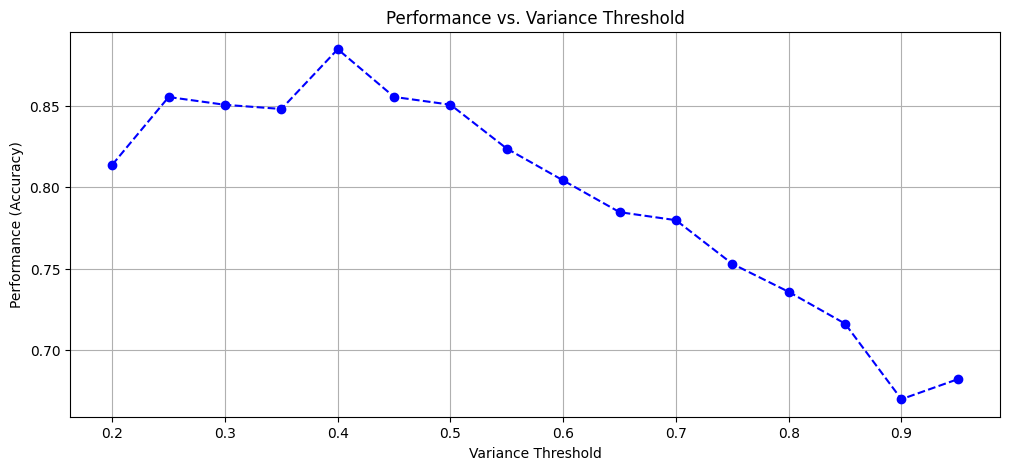

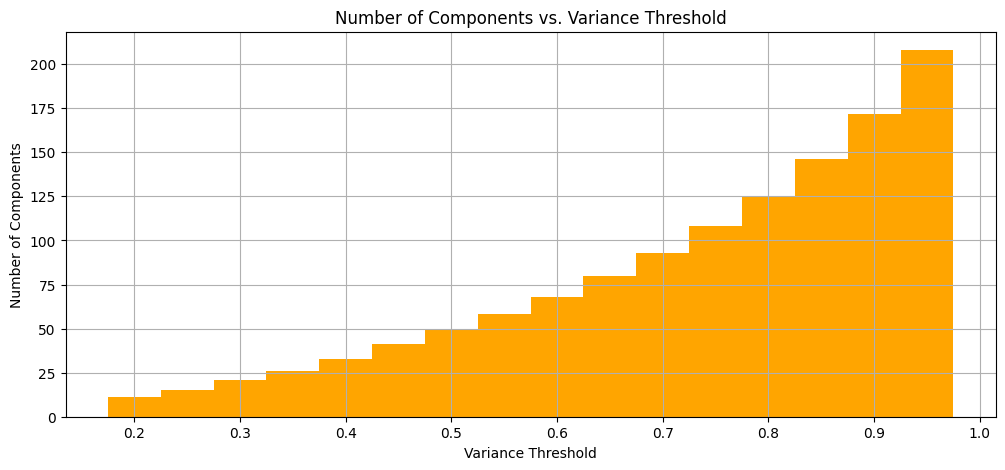

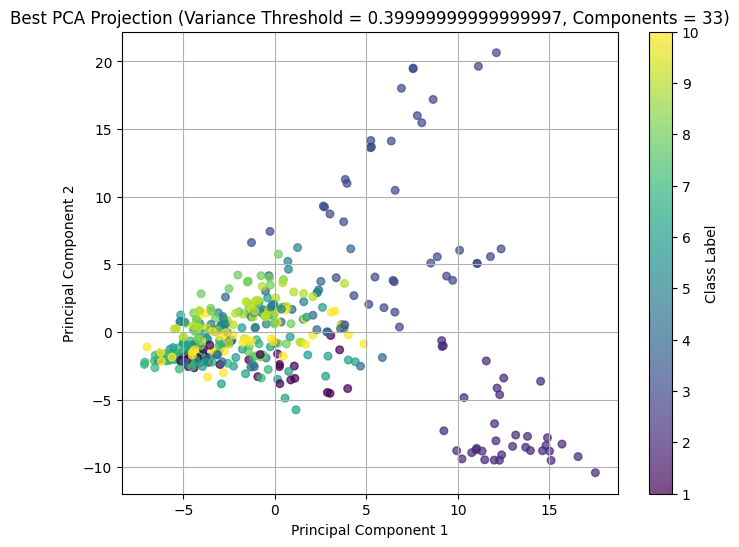

Best Variance Threshold: 0.39999999999999997, Components: 33, Best Score: 0.8850
Optimal number of components to retain 20.0% variance: 7
Variance Threshold: 0.2, Components: 7, Score: 0.7549
Optimal number of components to retain 25.0% variance: 10
Variance Threshold: 0.25, Components: 10, Score: 0.8030
Optimal number of components to retain 30.0% variance: 13
Variance Threshold: 0.3, Components: 13, Score: 0.7858
Optimal number of components to retain 35.0% variance: 17
Variance Threshold: 0.35, Components: 17, Score: 0.7944
Optimal number of components to retain 40.0% variance: 20
Variance Threshold: 0.39999999999999997, Components: 20, Score: 0.7904
Optimal number of components to retain 44.99999999999999% variance: 25
Variance Threshold: 0.44999999999999996, Components: 25, Score: 0.7729
Optimal number of components to retain 49.99999999999999% variance: 30
Variance Threshold: 0.49999999999999994, Components: 30, Score: 0.7684
Optimal number of components to retain 54.999999999999

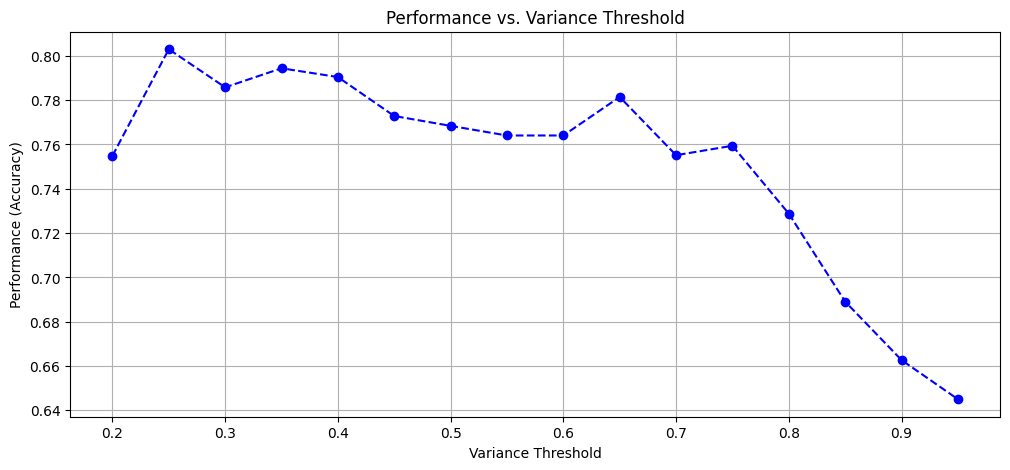

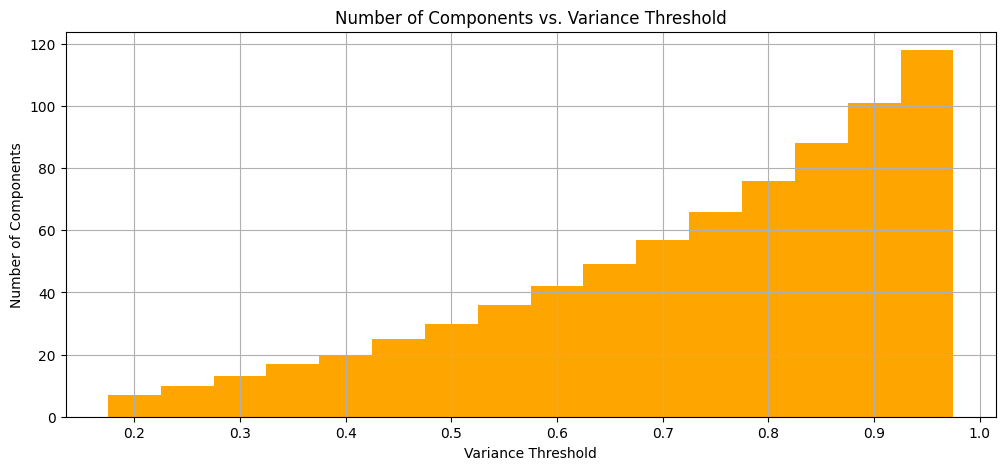

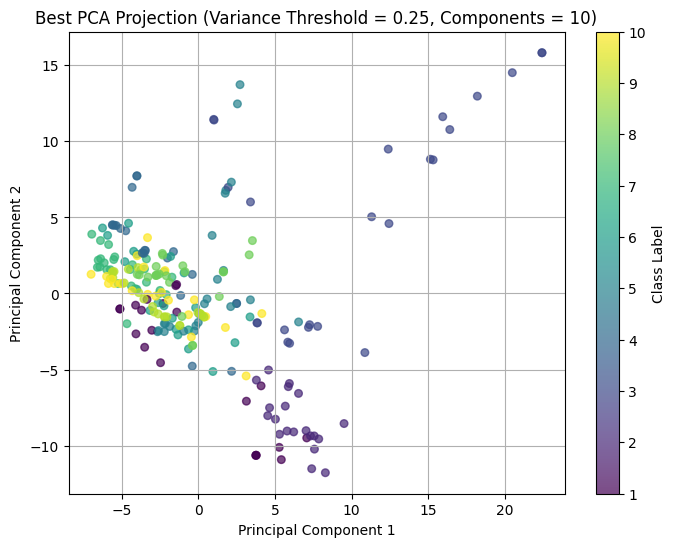

Best Variance Threshold: 0.25, Components: 10, Best Score: 0.8030
Optimal number of components to retain 20.0% variance: 3
Variance Threshold: 0.2, Components: 3, Score: 0.9315
Optimal number of components to retain 25.0% variance: 5
Variance Threshold: 0.25, Components: 5, Score: 0.9780
Optimal number of components to retain 30.0% variance: 6
Variance Threshold: 0.3, Components: 6, Score: 0.9829
Optimal number of components to retain 35.0% variance: 8
Variance Threshold: 0.35, Components: 8, Score: 0.9902
Optimal number of components to retain 40.0% variance: 10
Variance Threshold: 0.39999999999999997, Components: 10, Score: 0.9902
Optimal number of components to retain 44.99999999999999% variance: 13
Variance Threshold: 0.44999999999999996, Components: 13, Score: 0.9927
Optimal number of components to retain 49.99999999999999% variance: 16
Variance Threshold: 0.49999999999999994, Components: 16, Score: 0.9902
Optimal number of components to retain 54.99999999999999% variance: 21
Vari

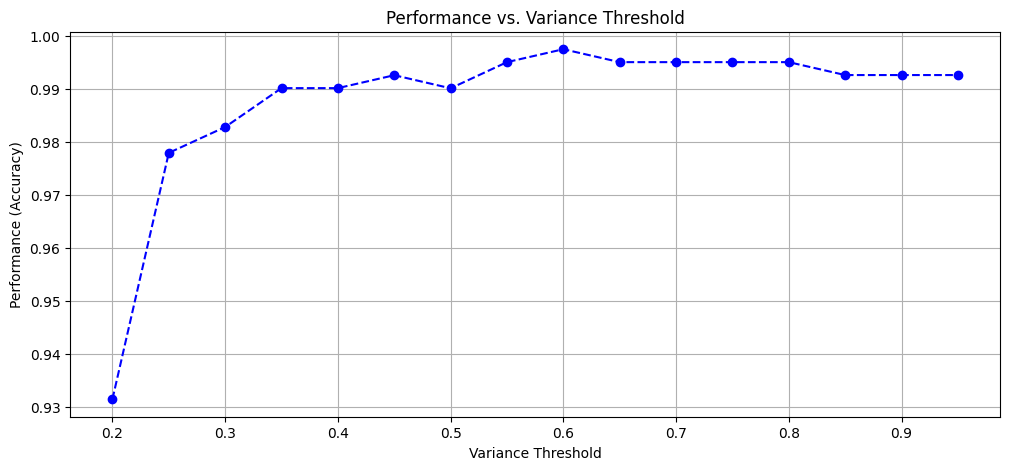

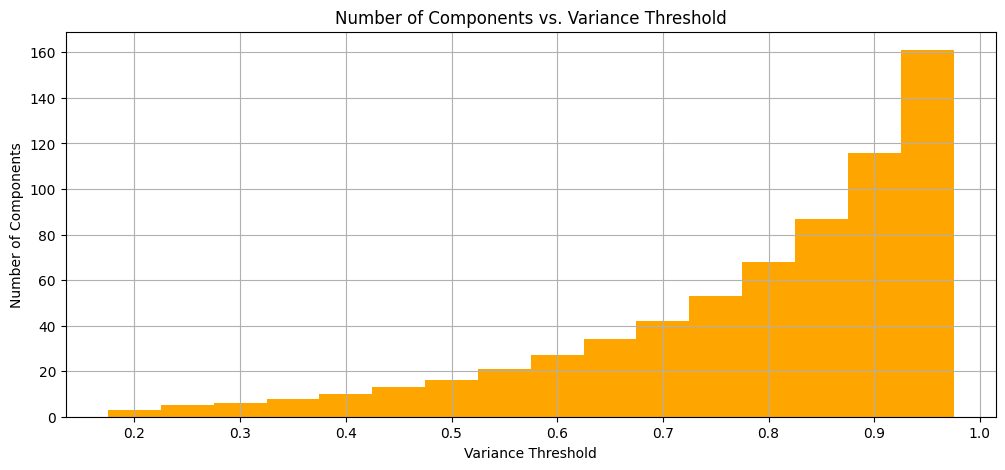

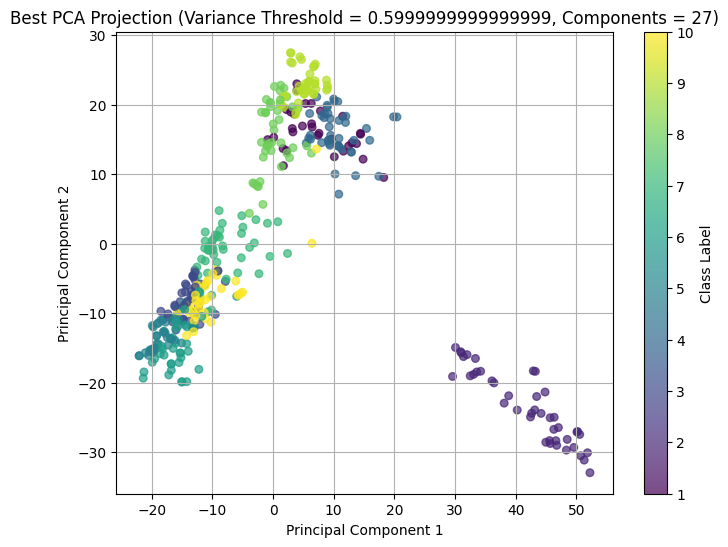

Best Variance Threshold: 0.5999999999999999, Components: 27, Best Score: 0.9976
Optimal number of components to retain 20.0% variance: 7
Variance Threshold: 0.2, Components: 7, Score: 0.7680
Optimal number of components to retain 25.0% variance: 10
Variance Threshold: 0.25, Components: 10, Score: 0.7940
Optimal number of components to retain 30.0% variance: 13
Variance Threshold: 0.3, Components: 13, Score: 0.7858
Optimal number of components to retain 35.0% variance: 17
Variance Threshold: 0.35, Components: 17, Score: 0.7988
Optimal number of components to retain 40.0% variance: 20
Variance Threshold: 0.39999999999999997, Components: 20, Score: 0.7904
Optimal number of components to retain 44.99999999999999% variance: 25
Variance Threshold: 0.44999999999999996, Components: 25, Score: 0.7510
Optimal number of components to retain 49.99999999999999% variance: 30
Variance Threshold: 0.49999999999999994, Components: 30, Score: 0.7817
Optimal number of components to retain 54.9999999999999

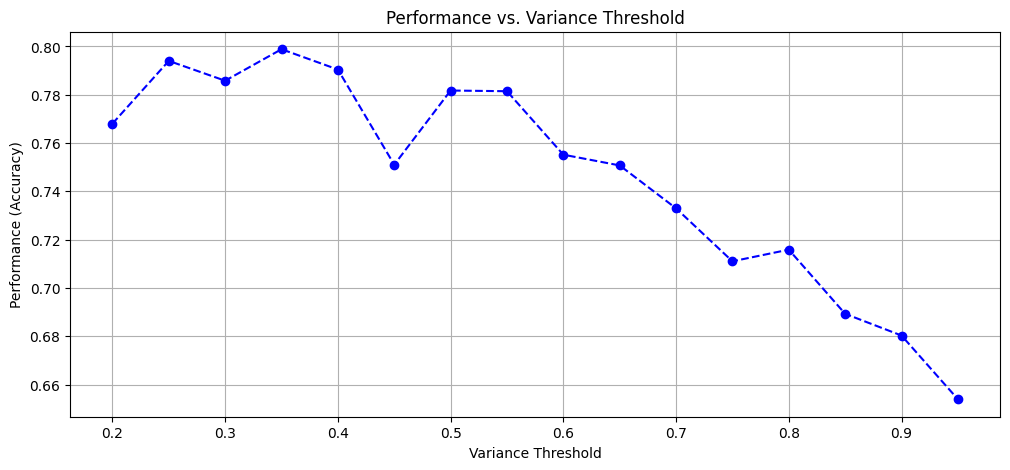

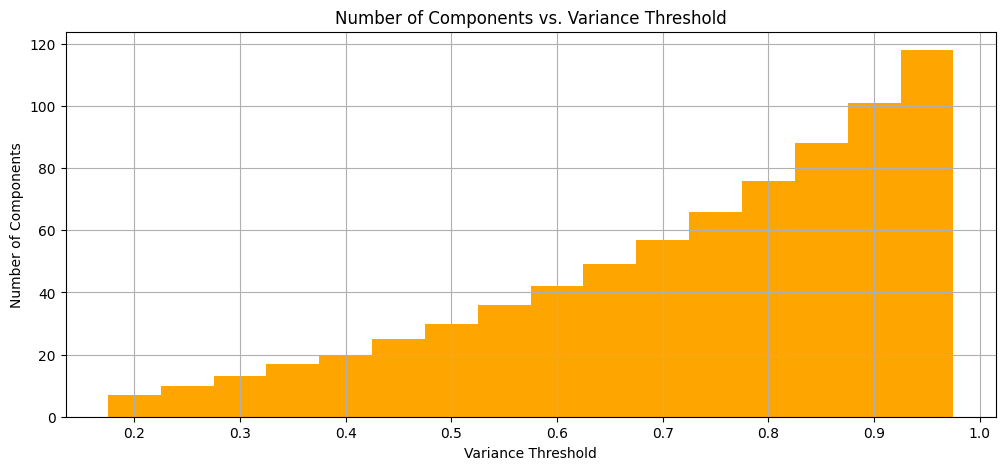

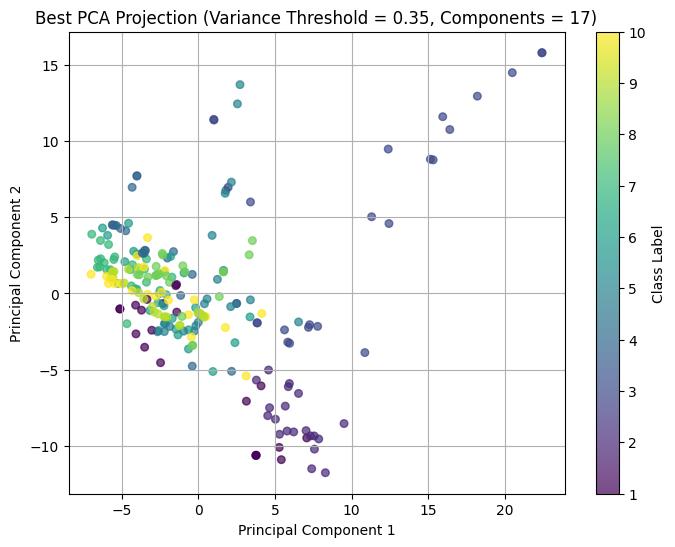

Best Variance Threshold: 0.35, Components: 17, Best Score: 0.7988
Best Variance Threshold for SURF Webcam: 0.39999999999999997, Components: 33, Best Score: 0.8850
Best Variance Threshold for SURF DSLR: 0.25, Components: 10, Best Score: 0.8030
Best Variance Threshold for CaffeNet Webcam: 0.5999999999999999, Components: 27, Best Score: 0.9976
Best Variance Threshold for CaffeNet DSLR: 0.35, Components: 17, Best Score: 0.7988


In [20]:
# Apply the best PCA tuning function on cleaned datasets

# For SURF Webcam dataset
best_pca_webcam_surf, best_variance_webcam_surf, best_d_webcam_surf, best_performance_webcam_surf = tune_pca_with_visualizations(
    X_webcam_clean_surf, y_webcam_clean_surf,
    thresholds=np.arange(0.20, 0.99, 0.05),
    classifier=KNeighborsClassifier(n_neighbors=3),
    cv=5,
    save_plots=True,
    plot_prefix="webcam_surf_pca_tuning"
)

# For SURF DSLR dataset
best_pca_dslr_surf, best_variance_dslr_surf, best_d_dslr_surf, best_performance_dslr_surf = tune_pca_with_visualizations(
    X_dslr_clean_surf, y_dslr_clean_surf,
    thresholds=np.arange(0.20, 0.99, 0.05),
    classifier=KNeighborsClassifier(n_neighbors=3),
    cv=5,
    save_plots=True,
    plot_prefix="dslr_surf_pca_tuning"
)

# For CaffeNet Webcam dataset
best_pca_webcam_caf, best_variance_webcam_caf, best_d_webcam_caf, best_performance_webcam_caf = tune_pca_with_visualizations(
    X_webcam_clean_caf, y_webcam_clean_caf,
    thresholds=np.arange(0.20, 0.99, 0.05),
    classifier=KNeighborsClassifier(n_neighbors=3),
    cv=5,
    save_plots=True,
    plot_prefix="webcam_caf_pca_tuning"
)

# For CaffeNet DSLR dataset
best_pca_dslr_caf, best_variance_dslr_caf, best_d_dslr_caf, best_performance_dslr_caf = tune_pca_with_visualizations(
    X_dslr_clean_caf, y_dslr_clean_caf,
    thresholds=np.arange(0.20, 0.99, 0.05),
    classifier=KNeighborsClassifier(n_neighbors=3),
    cv=5,
    save_plots=True,
    plot_prefix="dslr_caf_pca_tuning"
)

# Display the results for each dataset
print(f"Best Variance Threshold for SURF Webcam: {best_variance_webcam_surf}, Components: {best_d_webcam_surf}, Best Score: {best_performance_webcam_surf:.4f}")
print(f"Best Variance Threshold for SURF DSLR: {best_variance_dslr_surf}, Components: {best_d_dslr_surf}, Best Score: {best_performance_dslr_surf:.4f}")
print(f"Best Variance Threshold for CaffeNet Webcam: {best_variance_webcam_caf}, Components: {best_d_webcam_caf}, Best Score: {best_performance_webcam_caf:.4f}")
print(f"Best Variance Threshold for CaffeNet DSLR: {best_variance_dslr_caf}, Components: {best_d_dslr_caf}, Best Score: {best_performance_dslr_caf:.4f}")


In [21]:
# For SURF Webcam dataset
X_webcam_pca_surf, _ = pca_with_dynamic_d(X_webcam_clean_surf, variance_threshold=best_variance_webcam_surf)
# For SURF DSLR dataset
X_dslr_pca_surf, _ = pca_with_dynamic_d(X_dslr_clean_surf, variance_threshold=best_variance_dslr_surf)
# For CaffeNet Webcam dataset
X_webcam_pca_caf, _ = pca_with_dynamic_d(X_webcam_clean_caf, variance_threshold=best_variance_webcam_caf)
# For CaffeNet DSLR dataset
X_dslr_pca_caf, _ = pca_with_dynamic_d(X_dslr_clean_caf, variance_threshold=best_variance_dslr_caf)


Optimal number of components to retain 40.0% variance: 33
Optimal number of components to retain 25.0% variance: 10
Optimal number of components to retain 59.999999999999986% variance: 27
Optimal number of components to retain 35.0% variance: 17


# Subspace alignment

In [30]:
# Import necessary libraries
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Step 1: Perform PCA Transformation
def perform_pca(X, n_components):
    """
    Perform PCA on the input data and return PCA-transformed data and eigenvectors.

    Args:
    - X: Feature matrix of shape (n_samples, n_features).
    - n_components: Number of principal components to retain.

    Returns:
    - X_pca: PCA-transformed data.
    - components: PCA components (eigenvectors).
    """
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    components = pca.components_
    return X_pca, components

# Step 2: Define Subspace Alignment Function
def subspace_alignment(source, target, source_eig, target_eig):
    """
    Perform subspace alignment of source features to the target features.

    Args:
    - source: PCA-transformed source features.
    - target: PCA-transformed target features.
    - source_eig: Source PCA eigenvectors.
    - target_eig: Target PCA eigenvectors.

    Returns:
    - aligned_source: Source features aligned to the target subspace.
    """
    # Compute the alignment matrix
    M = np.dot(source_eig.T, target_eig)
    
    # Align the source features using the alignment matrix
    aligned_source = np.dot(source, M)
    
    return aligned_source

# Step 3: PCA Transformation for Both Datasets
# Use the previously cleaned and preprocessed datasets
# Webcam Dataset
X_webcam_pca, E_webcam = perform_pca(X_webcam_clean_caf, n_components=29)

# DSLR Dataset
X_dslr_pca, E_dslr = perform_pca(X_dslr_clean_caf, n_components=29)

# Step 4: Perform Subspace Alignment
X_webcam_aligned = subspace_alignment(X_webcam_pca, X_dslr_pca, E_webcam, E_dslr)
print(f"Shape of aligned CaffeNet Webcam dataset: {X_webcam_aligned.shape}")

# Step 5: Train a Model on Aligned Data and Evaluate
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_webcam_aligned, y_webcam_clean_caf)

# Predict on target data (DSLR) using the classifier trained on aligned source data
y_pred = classifier.predict(X_dslr_pca)

# Evaluate performance on the target domain
accuracy = accuracy_score(y_dslr_clean_caf, y_pred)
print(f"Subspace Alignment Accuracy on CaffeNet DSLR Dataset: {accuracy:.4f}")


ValueError: shapes (408,29) and (4096,800) not aligned: 29 (dim 1) != 4096 (dim 0)